# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pe
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import optuna
import joblib

In [2]:
warnings.filterwarnings("ignore")

# Data Cleaning and EDA

In [4]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv", index_col="id")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv", index_col="id")

In [5]:
train_df.head()

Name  Gender   Age           City Working Professional or Student  \
id                                                                          
0   Aaradhya  Female  49.0       Ludhiana            Working Professional   
1      Vivan    Male  26.0       Varanasi            Working Professional   
2     Yuvraj    Male  33.0  Visakhapatnam                         Student   
3     Yuvraj    Male  22.0         Mumbai            Working Professional   
4       Rhea  Female  30.0         Kanpur            Working Professional   

          Profession  Academic Pressure  Work Pressure  CGPA  \
id                                                             
0               Chef                NaN            5.0   NaN   
1            Teacher                NaN            4.0   NaN   
2                NaN                5.0            NaN  8.97   
3            Teacher                NaN            5.0   NaN   
4   Business Analyst                NaN            1.0   NaN   

    Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
id                                                                           
0                  NaN               2.0  More than 8 hours        Healthy   
1                  NaN               3.0  Less than 5 hours      Unhealthy   
2                  2.0               NaN          5-6 hours        Healthy   
3                  NaN               1.0  Less than 5 hours       Moderate   
4                  NaN               1.0          5-6 hours      Unhealthy   

     Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
id                                                                    
0       BHM                                    No               1.0   
1       LLB                                   Yes               7.0   
2   B.Pharm                                   Yes               3.0   
3       BBA                                   Yes              10.0   
4       BBA                                   Yes               9.0   

    Financial Stress Family History of Mental Illness  Depression  
id                                                                 
0                2.0                               No           0  
1                3.0                               No           1  
2                1.0                               No           1  
3                1.0                              Yes           1  
4                4.0                              Yes           0

In [6]:
test_df.head()

Name  Gender   Age           City Working Professional or Student  \
id                                                                             
140700   Shivam    Male  53.0  Visakhapatnam            Working Professional   
140701    Sanya  Female  58.0        Kolkata            Working Professional   
140702     Yash    Male  53.0         Jaipur            Working Professional   
140703   Nalini  Female  23.0         Rajkot                         Student   
140704  Shaurya    Male  47.0         Kalyan            Working Professional   

                    Profession  Academic Pressure  Work Pressure  CGPA  \
id                                                                       
140700                   Judge                NaN            2.0   NaN   
140701  Educational Consultant                NaN            2.0   NaN   
140702                 Teacher                NaN            4.0   NaN   
140703                     NaN                5.0            NaN  6.84   
140704                 Teacher                NaN            5.0   NaN   

        Study Satisfaction  Job Satisfaction     Sleep Duration  \
id                                                                
140700                 NaN               5.0  Less than 5 hours   
140701                 NaN               4.0  Less than 5 hours   
140702                 NaN               1.0          7-8 hours   
140703                 1.0               NaN  More than 8 hours   
140704                 NaN               5.0          7-8 hours   

       Dietary Habits  Degree Have you ever had suicidal thoughts ?  \
id                                                                    
140700       Moderate     LLB                                    No   
140701       Moderate    B.Ed                                    No   
140702       Moderate  B.Arch                                   Yes   
140703       Moderate     BSc                                   Yes   
140704       Moderate     BCA                                   Yes   

        Work/Study Hours  Financial Stress Family History of Mental Illness  
id                                                                           
140700               9.0               3.0                              Yes  
140701               6.0               4.0                               No  
140702              12.0               4.0                               No  
140703              10.0               4.0                               No  
140704               3.0               4.0                               No

In [7]:
train_df.shape

(140700, 19)

In [8]:
test_df.shape

(93800, 18)

In [9]:
columns = train_df.columns.tolist()

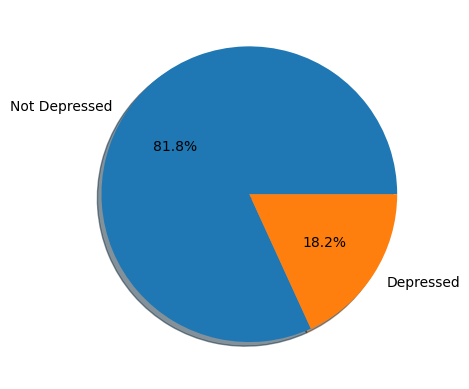

In [10]:
depression_classes = ["Not Depressed", "Depressed"]
value_counts = train_df.Depression.value_counts().values.tolist()
plt.pie(value_counts, labels=depression_classes, shadow=True, autopct='%1.1f%%')
plt.show()

The pie chart highlights a significant **class imbalance** in the dataset:

- **Not Depressed (0): 81.8%**
- **Depressed (1): 18.2%**

This imbalance indicates that the majority of individuals in the dataset do not suffer from depression. Such a skewed distribution can negatively impact the performance of machine learning models, as they may become biased toward the majority class.

To address this issue, I may consider applying techniques such as:

- **Evaluation metrics**: Using metrics like F1-score, precision, recall, and confusion matrix instead of just accuracy.

Handling this imbalance is crucial to ensure the model performs well on both classes, especially the minority class representing depressed individuals.


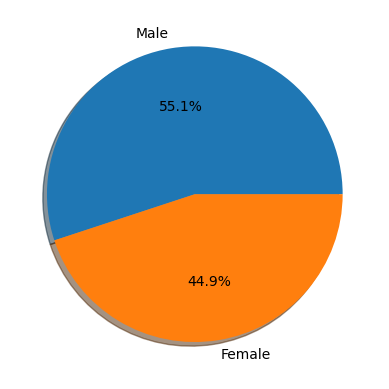

In [11]:
male_counts = train_df[train_df.Gender == "Male"].shape[0]
female_counts = train_df[train_df.Gender == "Female"].shape[0]
gender_labels = ["Male", "Female"]
values = [male_counts, female_counts]
plt.pie(values, labels=gender_labels, shadow=True, autopct='%1.1f%%')
plt.show()

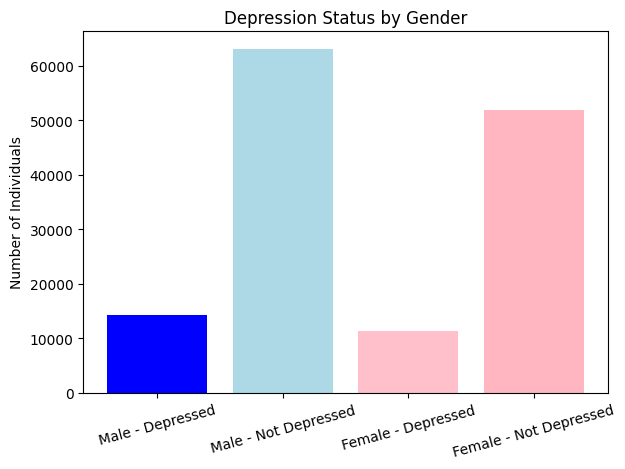

In [12]:
male_depressed = train_df[(train_df.Gender == "Male") & (train_df.Depression == 1)].shape[0]
male_not_depressed = train_df[(train_df.Gender == "Male") & (train_df.Depression == 0)].shape[0]
female_depressed = train_df[(train_df.Gender == "Female") & (train_df.Depression == 1)].shape[0]
female_not_depressed = train_df[(train_df.Gender == "Female") & (train_df.Depression == 0)].shape[0]

labels = ["Male - Depressed", "Male - Not Depressed", "Female - Depressed", "Female - Not Depressed"]
values = [male_depressed, male_not_depressed, female_depressed, female_not_depressed]

plt.bar(labels, values, color=["blue", "lightblue", "pink", "lightpink"])
plt.ylabel("Number of Individuals")
plt.title("Depression Status by Gender")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

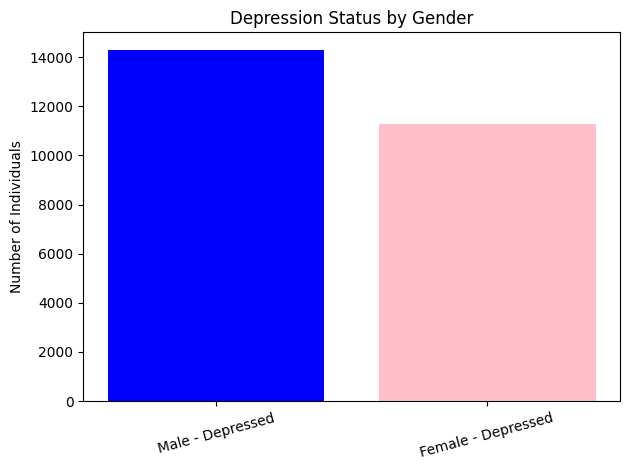

In [13]:
labels = ["Male - Depressed", "Female - Depressed"]
values = [male_depressed, female_depressed]

plt.bar(labels, values, color=["blue", "pink"])
plt.ylabel("Number of Individuals")
plt.title("Depression Status by Gender")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

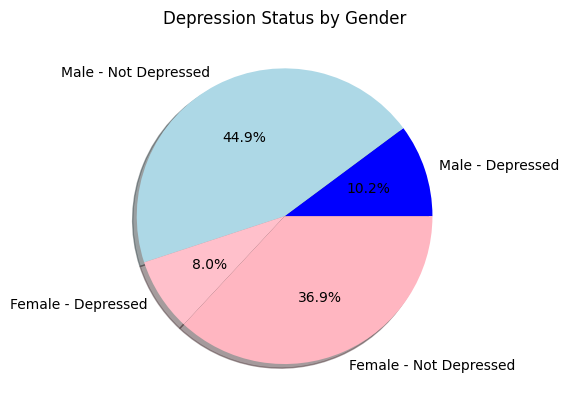

In [14]:
labels = ["Male - Depressed", "Male - Not Depressed", "Female - Depressed", "Female - Not Depressed"]
values = [male_depressed, male_not_depressed, female_depressed, female_not_depressed]

plt.pie(values, labels=labels, colors=["blue", "lightblue", "pink", "lightpink"], shadow=True, 
        autopct='%1.1f%%')
plt.title("Depression Status by Gender")
plt.show()

The bar charts indicate that **males exhibit a higher prevalence of depression compared to females**, suggesting that **gender may play a significant role** in depression-related patterns.

Additionally, the dataset appears to be relatively balanced in terms of gender distribution:

- **Males**: 55%
- **Females**: 45%

This balance ensures that gender-based patterns can be learned by the model without introducing bias due to unequal representation. Given the observed difference in depression rates between genders, **gender should be retained as an important feature during model training**.


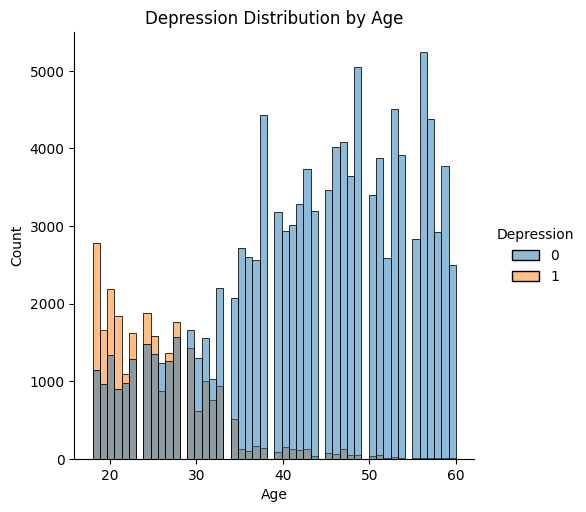

In [15]:
sns.displot(data=train_df, x=train_df.Age, hue=train_df.Depression)
plt.title("Depression Distribution by Age")
plt.show()

The distribution plots reveal a clear trend: **depression is more prevalent among younger individuals**. This indicates that age is a significant factor influencing depression and should be treated accordingly during feature engineering.

To better capture this trend, I plan to perform **binning on the **Age column**. Based on the visual patterns observed in the distribution chart, the following four age bins appear to be the most appropriate:

- **Teenagers** (≤ 20 years)  
- **Young Adults** (21–29 years)  
- **Adults** (30–39 years)  
- **Middle-aged and Older** (≥ 40 years)

Binning the age column in this manner can help the model identify age-related patterns more effectively and potentially improve its predictive performance.


In [16]:
train_df.City.unique()

array(['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur',
       'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot',
       'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat',
       'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata',
       'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
       'Bhopal', 'Indore', 'Ishanabad', 'Vidhi', 'Ayush', 'Gurgaon',
       'Krishna', 'Aishwarya', 'Keshav', 'Harsha', 'Nalini', 'Aditya',
       'Malyansh', 'Raghavendra', 'Saanvi', 'M.Tech', 'Bhavna',
       'Less Delhi', 'Nandini', 'M.Com', 'Plata', 'Atharv', 'Pratyush',
       'City', '3.0', 'Less than 5 Kalyan', 'MCA', 'Mira', 'Moreadhyay',
       'Morena', 'Ishkarsh', 'Kashk', 'Mihir', 'Vidya', 'Tolkata', 'Anvi',
       'Krinda', 'Ayansh', 'Shrey', 'Ivaan', 'Vaanya', 'Gaurav', 'Harsh',
       'Reyansh', 'Kashish', 'Kibara', 'Vaishnavi', 'Chhavi', 'Parth',
       'Mahi', 'Tushar', 'MSc', 'No', 'Rashi', 'ME', 'Molkata',
       'Researcher', '

In [17]:
train_df.City.replace("Tolkata", "Kolkata", inplace=True)
train_df.City.replace("Khaziabad", "Ghaziabad", inplace=True)
train_df.City.replace("Less Delhi", "Delhi", inplace=True)
train_df.City.replace("Molkata", "Kolkata", inplace=True)
train_df.City.replace("Less than 5 Kalyan", "Kalyan", inplace=True)
train_df.City.replace("Nalyan", "Kalyan", inplace=True)
train_df.City.replace("Malyan", "Kalyan", inplace=True)
train_df.City.replace("Mhopal", "Bhopal", inplace=True)
train_df.City.replace("Is Kanpur", "Kanpur", inplace=True)
train_df.City.replace("Golkata", "Kolkata", inplace=True)
train_df.City.replace("Vaikot", "Varkot", inplace=True)
train_df.City.replace("San Vasai-Virar", "Vasai-Virar", inplace=True)
train_df.City.replace("More Delhi", "Delhi", inplace=True)
train_df.City.replace("Rolkata", "Kolkata", inplace=True)
train_df.City.replace("Ghopal", "Bhopal", inplace=True)
train_df.City.replace("Thani", "Thane", inplace=True)

test_df.City.replace("Tolkata", "Kolkata", inplace=True)
test_df.City.replace("Khaziabad", "Ghaziabad", inplace=True)
test_df.City.replace("Less Delhi", "Delhi", inplace=True)
test_df.City.replace("Molkata", "Kolkata", inplace=True)
test_df.City.replace("Less than 5 Kalyan", "Kalyan", inplace=True)
test_df.City.replace("Nalyan", "Kalyan", inplace=True)
test_df.City.replace("Malyan", "Kalyan", inplace=True)
test_df.City.replace("Mhopal", "Bhopal", inplace=True)
test_df.City.replace("Is Kanpur", "Kanpur", inplace=True)
test_df.City.replace("Golkata", "Kolkata", inplace=True)
test_df.City.replace("Vaikot", "Varkot", inplace=True)
test_df.City.replace("San Vasai-Virar", "Vasai-Virar", inplace=True)
test_df.City.replace("More Delhi", "Delhi", inplace=True)
test_df.City.replace("Rolkata", "Kolkata", inplace=True)
test_df.City.replace("Ghopal", "Bhopal", inplace=True)
test_df.City.replace("Thani", "Thane", inplace=True)

In [18]:
train_df.City.unique()

array(['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur',
       'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot',
       'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat',
       'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata',
       'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
       'Bhopal', 'Indore', 'Ishanabad', 'Vidhi', 'Ayush', 'Gurgaon',
       'Krishna', 'Aishwarya', 'Keshav', 'Harsha', 'Nalini', 'Aditya',
       'Malyansh', 'Raghavendra', 'Saanvi', 'M.Tech', 'Bhavna', 'Nandini',
       'M.Com', 'Plata', 'Atharv', 'Pratyush', 'City', '3.0', 'MCA',
       'Mira', 'Moreadhyay', 'Morena', 'Ishkarsh', 'Kashk', 'Mihir',
       'Vidya', 'Anvi', 'Krinda', 'Ayansh', 'Shrey', 'Ivaan', 'Vaanya',
       'Gaurav', 'Harsh', 'Reyansh', 'Kashish', 'Kibara', 'Vaishnavi',
       'Chhavi', 'Parth', 'Mahi', 'Tushar', 'MSc', 'No', 'Rashi', 'ME',
       'Researcher', 'Kagan', 'Armaan', 'Ithal', 'Dhruv', 'Galesabad',
       'Itheg', 

In [19]:
test_df.City.unique()

array(['Visakhapatnam', 'Kolkata', 'Jaipur', 'Rajkot', 'Kalyan', 'Mumbai',
       'Surat', 'Srinagar', 'Delhi', 'Lucknow', 'Thane', 'Meerut',
       'Nagpur', 'Ghaziabad', 'Chennai', 'Varanasi', 'Indore', 'Pune',
       'Hyderabad', 'Kanpur', 'Nashik', 'Bhopal', 'Faridabad',
       'Bangalore', 'Vasai-Virar', 'Ludhiana', 'Patna', 'Vadodara',
       'Ahmedabad', 'Agra', 'Pratyush', 'Vidya', 'Less than 5 hours',
       'Aditi', 'Keshav', 'Nalini', 'Avni', 'Ira', 'Vaishnavi', 'Bhavna',
       'Lawyer', 'Hrithik', 'City', 'Unaly', 'Sara', 'Saurav', 'Vikram',
       'Parth', 'Siddhesh', 'Varkot', 'Leela', 'Chemist', 'No', 'Saanvi',
       'Pratham', 'Vidhi', 'Abhinav', 'No.12'], dtype=object)

In [20]:
train_invalid_cities = [
    "Ishanabad", "Vidhi", "Ayush", "Krishna", "Aishwarya", "Keshav", "Harsha",
    "Nalini", "Aditya", "Malyansh", "Raghavendra", "Saanvi", "Bhavna", "Nandini",
    "Plata", "Atharv", "Pratyush", "Anvi", "Krinda", "Ayansh", "Shrey", "Ivaan",
    "Vaanya", "Gaurav", "Harsh", "Reyansh", "Kashish", "Kibara", "Vaishnavi",
    "Chhavi", "Parth", "Mahi", "Tushar", "Rashi", "Kagan", "Armaan", "Ithal",
    "Nalyan", "Dhruv", "Galesabad", "Itheg", "Aaradhya", "Pooja", "Khushi",
    "Jhanvi", "Unirar", "Ishkarsh", "Kashk", "Vidya", "Moreadhyay",
     "3.0", "City", "M.Tech", "M.Com", "MCA", "MSc", "ME", "Researcher", "No"]
test_invalid_cities = ["Pratyush", "Vidya", "Less than 5 hours", "Aditi", "Keshav", "Nalini","Avni",             
    "Ira", "Vaishnavi","Bhavna","Lawyer","Hrithik","City","Unaly","Is Kanpur","Sara","Saurav",            
    "Vikram","Parth","Siddhesh","Leela","Chemist","No","Saanvi","Pratham","Vidhi","Abhinav","No.12"]

all_invalid_cities = train_invalid_cities + test_invalid_cities
invalid_cities = list(set(all_invalid_cities))
train_fake_city_counts = train_df[train_df["City"].isin(invalid_cities)].shape[0]
test_fake_city_counts = test_df[test_df["City"].isin(invalid_cities)].shape[0]
fake_city_counts = train_fake_city_counts + test_fake_city_counts
fake_city_counts

120

In [21]:
#train_df.drop(train_df[train_df["City"].isin(invalid_cities)].index, inplace=True)
## Should not Run this after realising City is not an important feature

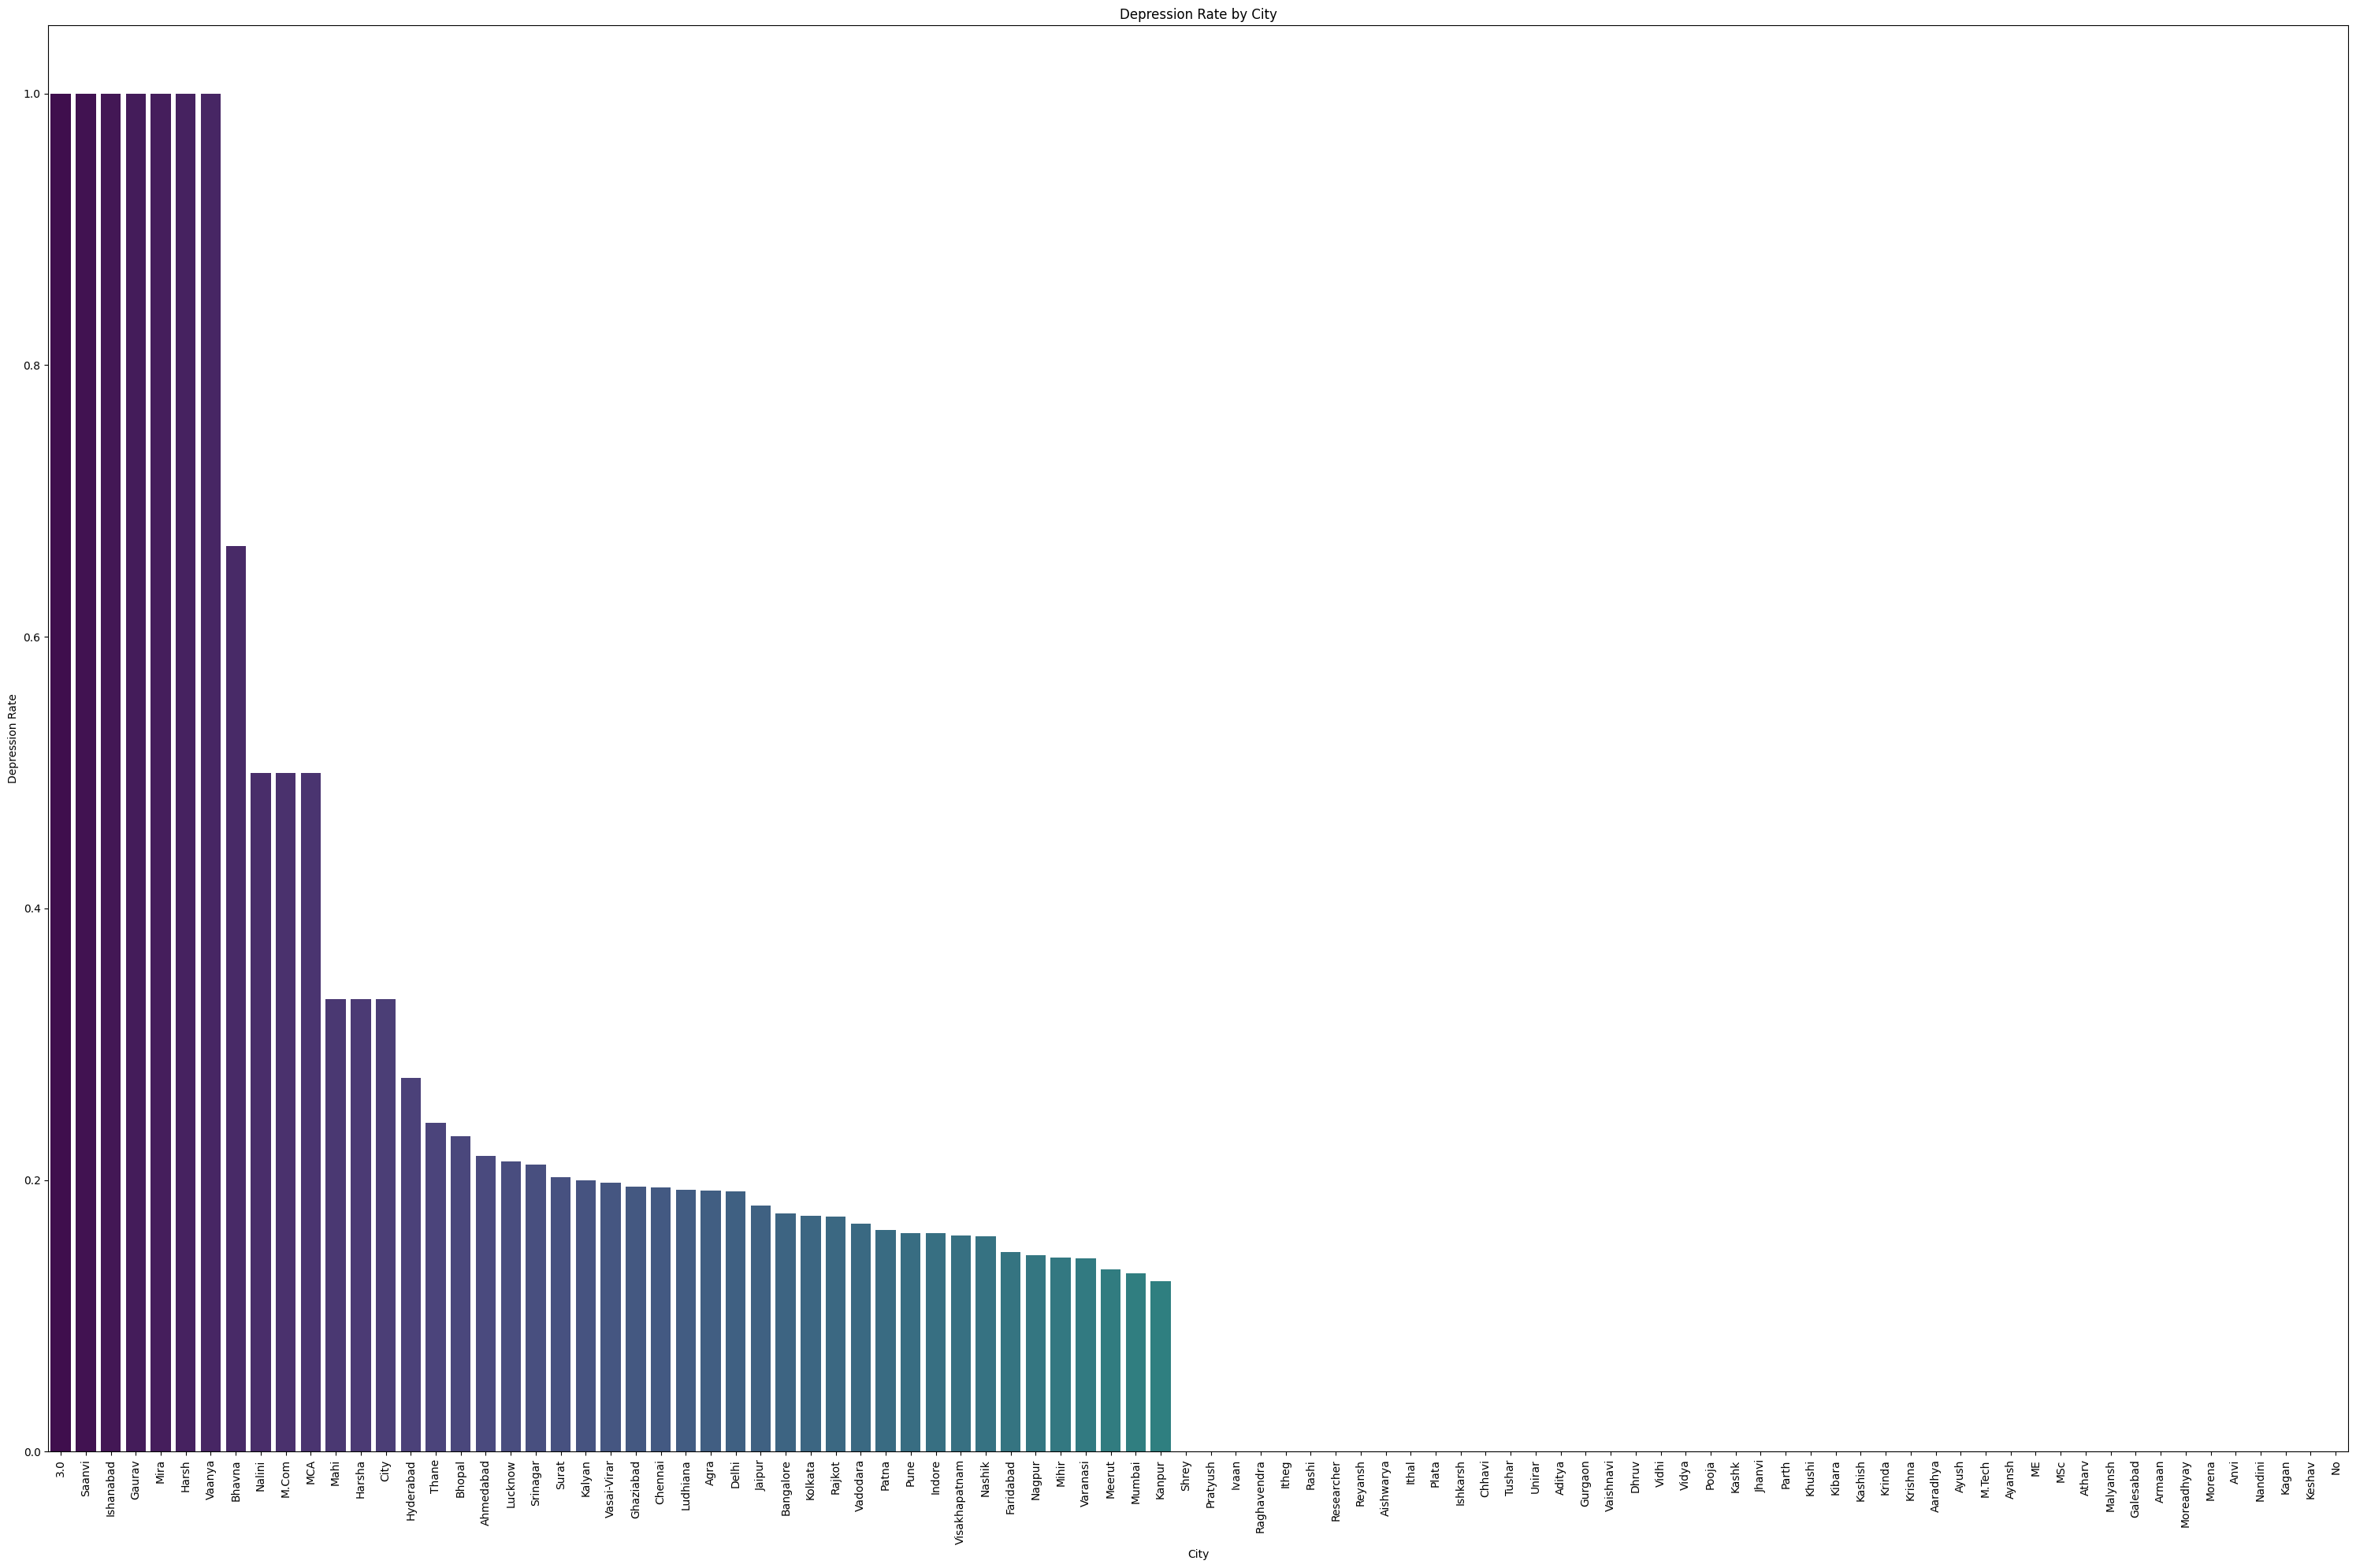

In [22]:
city_depression = train_df.groupby("City")["Depression"].mean().sort_values(ascending=False)

plt.figure(figsize=(30, 20))
sns.barplot(x=city_depression.index, y=city_depression.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Depression Rate")
plt.title("Depression Rate by City")
plt.tight_layout()
plt.show()

In [23]:
train_df[train_df.City == "Mira"].shape

(1, 19)

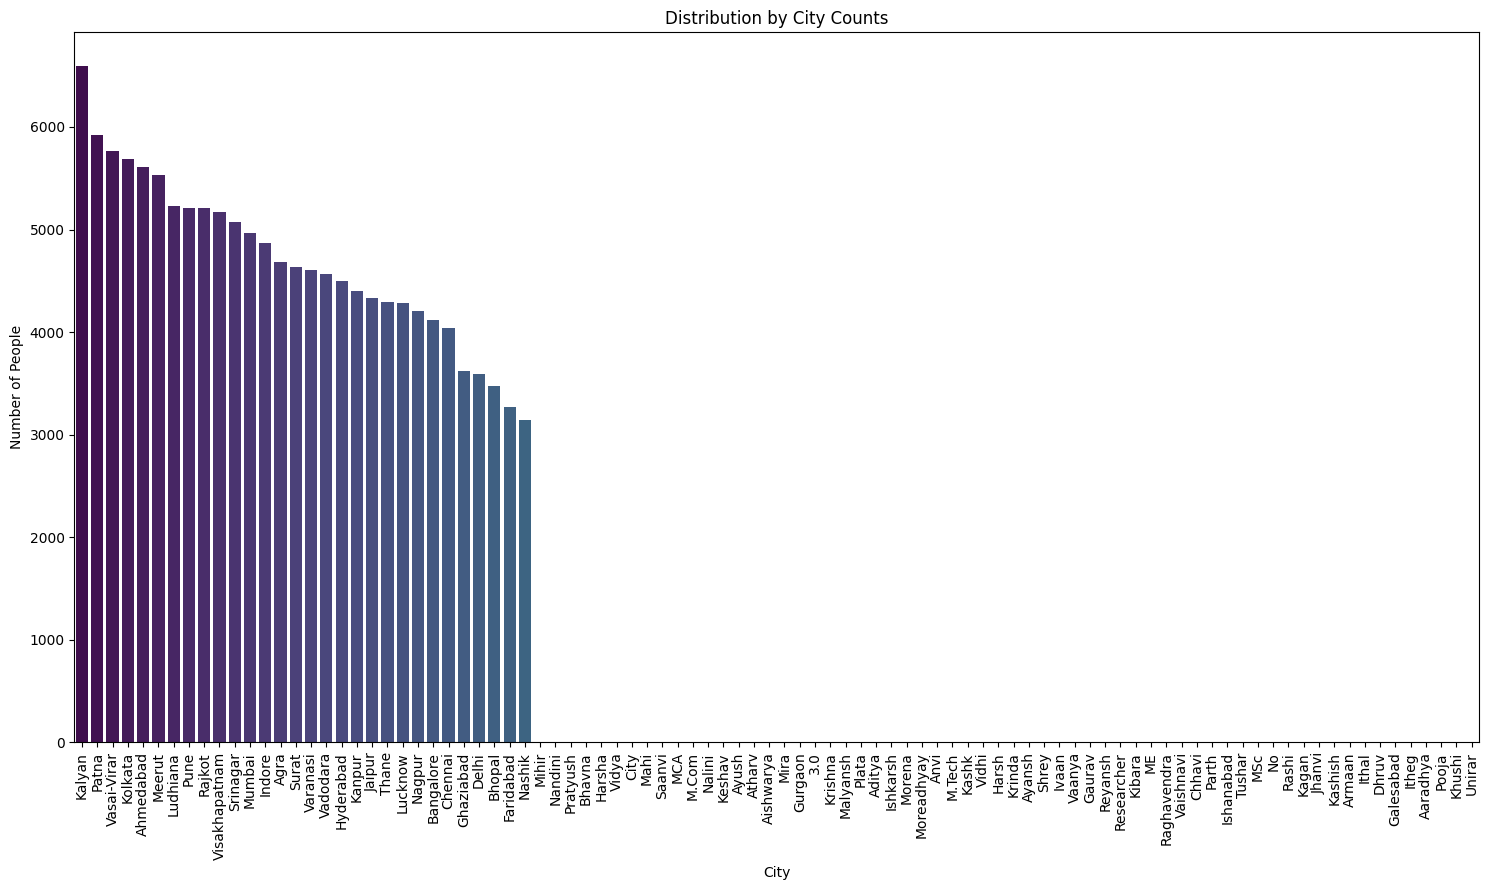

In [24]:
city_counts = train_df.City.value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 9))
sns.barplot(x=city_counts.index, y=city_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Number of People")
plt.title("Distribution by City Counts")
plt.tight_layout()
plt.show()

The analysis of the **City** attribute in relation to depression rates suggests that **city does not play a significant role in influencing depression**.

- Most cities show a **consistent depression rate** ranging between **0.15 and 0.20**, indicating little variation across locations.
- Some **outliers** exist, such as:
  - **Mira**, with a depression rate of **1.0**, but it only includes **one record**, making it statistically unreliable.
  - **Mihir**, **Gurgaon**, and **Morena** also have **very low representation**, reducing the reliability of their depression statistics.

Additionally, the **distribution of records per city** is generally uniform, with the majority having around **5,000 records**, supporting the idea of a balanced dataset across most cities.

Since the **City** feature does not provide meaningful variation or predictive power for depression and includes noisy entries, it is reasonable to **drop the 'City' column** for downstream analysis or modeling.


In [25]:
train_df["Working Professional or Student"].unique()

array(['Working Professional', 'Student'], dtype=object)

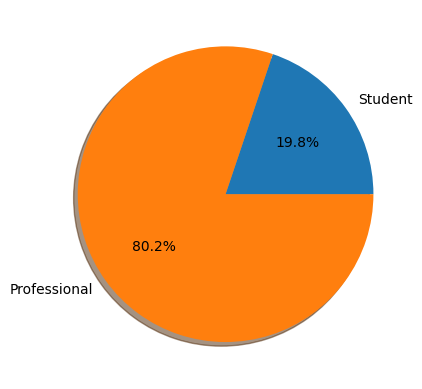

In [26]:
student_counts = train_df[train_df["Working Professional or Student"] == "Student"].shape[0]
professional_counts = train_df[train_df["Working Professional or Student"] == "Working Professional"].shape[0]
working_labels = ["Student", "Professional"]

counts = [student_counts, professional_counts]

plt.pie(counts, labels=working_labels, shadow=True, autopct='%1.1f%%')
plt.show()

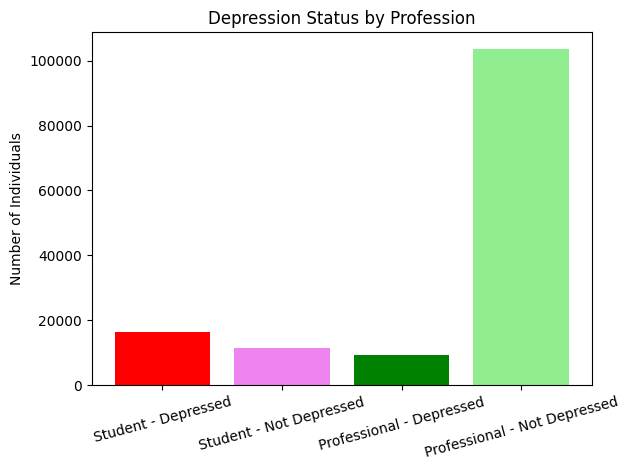

In [27]:
student_depressed = train_df[(train_df["Working Professional or Student"] == "Student") & (train_df.Depression == 1)].shape[0]
student_not_depressed = train_df[(train_df["Working Professional or Student"] == "Student") & (train_df.Depression == 0)].shape[0]
professional_depressed = train_df[(train_df["Working Professional or Student"] == "Working Professional") & (train_df.Depression == 1)].shape[0]
professional_not_depressed = train_df[(train_df["Working Professional or Student"] == "Working Professional") & (train_df.Depression == 0)].shape[0]

labels = ["Student - Depressed", "Student - Not Depressed", "Professional - Depressed", "Professional - Not Depressed"]
values = [student_depressed, student_not_depressed, professional_depressed, professional_not_depressed]

plt.bar(labels, values, color=["red", "violet", "green", "lightgreen"])
plt.ylabel("Number of Individuals")
plt.title("Depression Status by Profession")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

The **pie chart and bar chart** comparisons reveal that **students exhibit higher depression rates** than professionals, **despite professionals comprising 80%** of the dataset and students only 20%.

This observation implies:
- **Students are more likely to be depressed** compared to professionals.
- However, the imbalance in representation (fewer student records) raises the possibility of a **sampling bias** — the student data might not fully represent the broader student population.

**Despite this limitation**, the trend in the available data still clearly indicates a higher rate of depression among students. Therefore:

- The **Working Professional or Student** column contains **valuable predictive information** and **should be retained**.
- To prepare it for modeling, **One-Hot Encoding** will be applied to convert the categorical values into a numerical format suitable for machine learning algorithms.


In [28]:
train_df["Academic Pressure"].unique()

array([nan,  5.,  2.,  3.,  4.,  1.])

In [29]:
train_df[train_df["Academic Pressure"].isnull()].shape

(112803, 19)

In [30]:
train_df[(train_df["Academic Pressure"].isnull()) & (train_df["Working Professional or Student"] == "Student")].shape

(9, 19)

In [31]:
train_df.drop(train_df[(train_df["Academic Pressure"].isnull()) & (train_df["Working Professional or Student"] == "Student")].index, inplace=True)

In [32]:
train_df[(train_df["Academic Pressure"].isnull()) & (train_df["Working Professional or Student"] == "Working Professional")].shape

(112794, 19)

In [33]:
test_df[test_df["Academic Pressure"].isnull()].shape

(75033, 18)

In [34]:
test_df[(test_df["Academic Pressure"].isnull()) & (test_df["Working Professional or Student"] == "Student")].shape

(7, 18)

In [35]:
test_df[(test_df["Academic Pressure"].isnull()) & (test_df["Working Professional or Student"] == "Working Professional")].shape

(75026, 18)

In [36]:
train_df["Academic Pressure"].fillna(0, inplace=True)
test_df["Academic Pressure"].fillna(0, inplace=True)

In [37]:
train_df["Academic Pressure"].isnull().sum()

0

In [38]:
train_df["Academic Pressure"].unique()

array([0., 5., 2., 3., 4., 1.])

In [39]:
train_df["Work Pressure"].unique()

array([ 5.,  4., nan,  1.,  2.,  3.])

In [40]:
train_df[train_df["Work Pressure"].isnull()].shape

(27912, 19)

In [41]:
train_df.drop(train_df[(train_df["Work Pressure"].isnull()) & (train_df["Working Professional or Student"] == "Working Professional")].index, inplace=True)

In [42]:
train_df[(train_df["Work Pressure"].isnull()) & (train_df["Working Professional or Student"] == "Student")].shape

(27892, 19)

In [43]:
test_df[test_df["Work Pressure"].isnull()].shape

(18778, 18)

In [44]:
test_df[(test_df["Work Pressure"].isnull()) & (test_df["Working Professional or Student"] == "Working Professional")].shape

(10, 18)

In [45]:
test_df[(test_df["Work Pressure"].isnull()) & (test_df["Working Professional or Student"] == "Student")].shape

(18768, 18)

In [46]:
train_df["Work Pressure"].fillna(0, inplace=True)
test_df["Work Pressure"].fillna(0, inplace=True)

In [47]:
train_df["Work Pressure"].isnull().sum()

0

The dataset contains two separate columns — **Academic Pressure** and **Work Pressure** — which capture the pressure experienced due to an individual's primary occupation. These columns are **conceptually similar** but are separated based on role:

- **Academic Pressure**: applies to individuals labeled as **Students**.
- **Work Pressure**: applies to individuals labeled as **Professionals**.

Although they are recorded separately, **both columns represent the same idea** — the **occupational stress** a person experiences. The distinction lies only in the role of the person, not in the meaning or scale of the data.

Since:
- The two columns are **mutually exclusive** (i.e., one is null when the other has a value),
- Their numerical values describe the **same concept**,
- There is already a separate column indicating whether a person is a **Student or Working Professional**,

It is both logical and efficient to **merge these into a single **Pressure column**.

This merged column will:
- Provide a cleaner, unified representation of pressure due to occupation,
- Eliminate unnecessary sparsity (from nulls and zeroes),

The original **Academic Pressure** and **Work Pressure** columns can then be dropped.

In [48]:
def CombineAcademicandWorkPressure(row):
    return row["Academic Pressure"] + row["Work Pressure"]
train_df["Pressure"] = train_df.apply(CombineAcademicandWorkPressure, axis=1)

In [49]:
test_df["Pressure"] = test_df.apply(CombineAcademicandWorkPressure, axis=1)

In [50]:
train_df.drop(columns=["Academic Pressure", "Work Pressure", "Name", "City"], inplace=True)
test_df.drop(columns=["Academic Pressure", "Work Pressure", "Name", "City"], inplace=True)

In [51]:
train_df["Study Satisfaction"].unique()

array([nan,  2.,  5.,  3.,  4.,  1.])

In [52]:
train_df[train_df["Study Satisfaction"].isnull()].shape

(112782, 16)

In [53]:
train_df[(train_df["Study Satisfaction"].isnull()) & (train_df["Working Professional or Student"] == "Student")].shape

(3, 16)

In [54]:
train_df.drop(train_df[(train_df["Study Satisfaction"].isnull()) & (train_df["Working Professional or Student"] == "Student")].index, inplace=True)

In [55]:
train_df[(train_df["Study Satisfaction"].isnull()) & (train_df["Working Professional or Student"] == "Working Professional")].shape

(112779, 16)

In [56]:
test_df[(test_df["Study Satisfaction"].isnull()) & (test_df["Working Professional or Student"] == "Student")].shape

(8, 15)

In [57]:
test_df[(test_df["Study Satisfaction"].isnull()) & (test_df["Working Professional or Student"] == "Working Professional")].shape

(75025, 15)

In [58]:
train_df["Study Satisfaction"].fillna(0, inplace=True)
test_df["Study Satisfaction"].fillna(0, inplace=True)

In [59]:
train_df["Job Satisfaction"].unique()

array([ 2.,  3., nan,  1.,  5.,  4.])

In [60]:
train_df[train_df["Job Satisfaction"].isnull()].shape

(27892, 16)

In [61]:
train_df[(train_df["Job Satisfaction"].isnull()) & (train_df["Working Professional or Student"] == "Working Professional")].shape

(5, 16)

In [62]:
train_df.drop(train_df[(train_df["Job Satisfaction"].isnull()) & (train_df["Working Professional or Student"] == "Working Professional")].index, inplace=True)

In [63]:
train_df[(train_df["Job Satisfaction"].isnull()) & (train_df["Working Professional or Student"] == "Student")].shape

(27887, 16)

In [64]:
train_df["Job Satisfaction"].fillna(0, inplace=True)
test_df["Job Satisfaction"].fillna(0, inplace=True)

A similar pattern is observed in the satisfaction-related columns:

- **Study Satisfaction**: reported by individuals identified as **Students**.
- **Job Satisfaction**: reported by individuals identified as **Working Professionals**.

Just like with the pressure columns, these satisfaction columns are:
- **Conceptually identical**, measuring satisfaction with one’s primary activity.
- **Mutually exclusive** based on the individual's occupation.
- Clearly separated by the **Working Professional or Student** indicator.

**Action Taken**:  
Combined these into a unified **Satisfaction** column for the same benefits:
- Reduced null values and dimensionality,
- Clearer and more meaningful analysis,
- More efficient model input preparation.

The original **Study Satisfaction** and **Job Satisfaction** columns were subsequently dropped.


In [65]:
def CombineStudyandJobSatisfaction(row):
    return row["Job Satisfaction"] + row["Study Satisfaction"]
train_df["Satisfaction"] = train_df.apply(CombineStudyandJobSatisfaction, axis=1)

In [66]:
test_df["Satisfaction"] = test_df.apply(CombineStudyandJobSatisfaction, axis=1)

In [67]:
train_df.drop(columns=["Job Satisfaction", "Study Satisfaction"], inplace=True)
test_df.drop(columns=["Job Satisfaction", "Study Satisfaction"], inplace=True)

In [68]:
train_df["Financial Stress"].unique()

array([ 2.,  3.,  1.,  4.,  5., nan])

In [69]:
train_df["Financial Stress"].isnull().sum()

4

In [70]:
test_df["Financial Stress"].isnull().sum()

0

In [71]:
train_df[(train_df["Financial Stress"].isnull()) & (train_df["Working Professional or Student"] == "Student")].shape

(3, 15)

In [72]:
mean_fin_stress_students = train_df.loc[train_df["Working Professional or Student"] == "Student","Financial Stress"].mean()
train_df.loc[(train_df["Financial Stress"].isnull()) & (train_df["Working Professional or Student"] == "Student"), "Financial Stress"] = mean_fin_stress_students

In [73]:
mean_fin_stress_professionals = train_df.loc[train_df["Working Professional or Student"] == "Working Professional","Financial Stress"].mean()
train_df.loc[(train_df["Financial Stress"].isnull()) & (train_df["Working Professional or Student"] == "Working Professional"),"Financial Stress"] = mean_fin_stress_professionals

In [74]:
train_df["Financial Stress"].isnull().sum()

0

In [75]:
train_df["Financial Stress"].unique()

array([2.        , 3.        , 1.        , 4.        , 5.        ,
       3.13974754, 2.95161076])

In [76]:
train_df["Financial Stress"] = train_df["Financial Stress"].round(0)

In [77]:
train_df["Financial Stress"].unique()

array([2., 3., 1., 4., 5.])

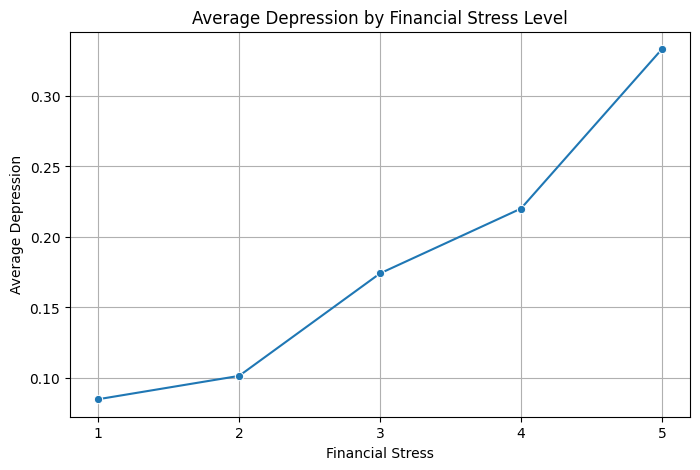

In [78]:
mean_dep = train_df.groupby("Financial Stress")["Depression"].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.lineplot(x="Financial Stress", y="Depression", data=mean_dep, marker="o")
plt.title("Average Depression by Financial Stress Level")
plt.xlabel("Financial Stress")
plt.ylabel("Average Depression")
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.show()

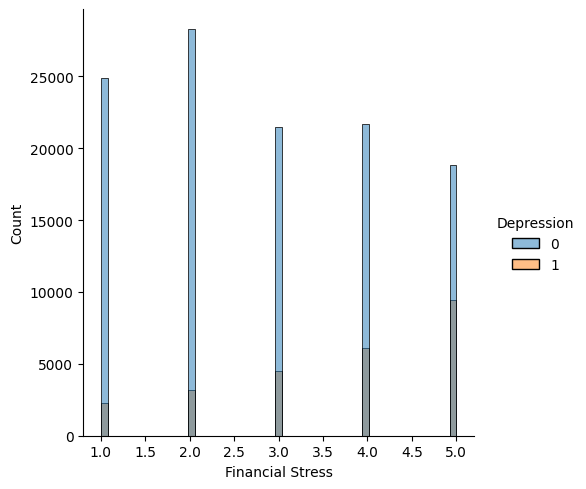

In [79]:
sns.displot(data=train_df, x=train_df["Financial Stress"], hue=train_df.Depression)
plt.show()

The visualizations reveal a **clear positive linear trend** between **Financial Stress** and **Depression** levels. As financial stress increases, there is a noticeable rise in depression scores across the dataset. Specifically:

- Individuals reporting **higher financial stress** (levels 4 and 5) tend to exhibit **significantly higher depression scores**.
- The **mean depression levels** increase steadily with each unit rise in financial stress, suggesting a **strong correlation**.
- The **distribution plot** indicate not only a rise in the median depression scores but also a concentration of higher depression values at higher stress levels.

**Conclusion:**  
There is compelling evidence from the data that **financial stress is strongly associated with higher depression levels**, suggesting the need for targeted mental health interventions among financially stressed individuals.


In [80]:
train_df["Family History of Mental Illness"].unique()

array(['No', 'Yes'], dtype=object)

In [81]:
test_df["Family History of Mental Illness"].unique()

array(['Yes', 'No'], dtype=object)

In [82]:
train_df["Family History of Mental Illness"].isnull().sum()

0

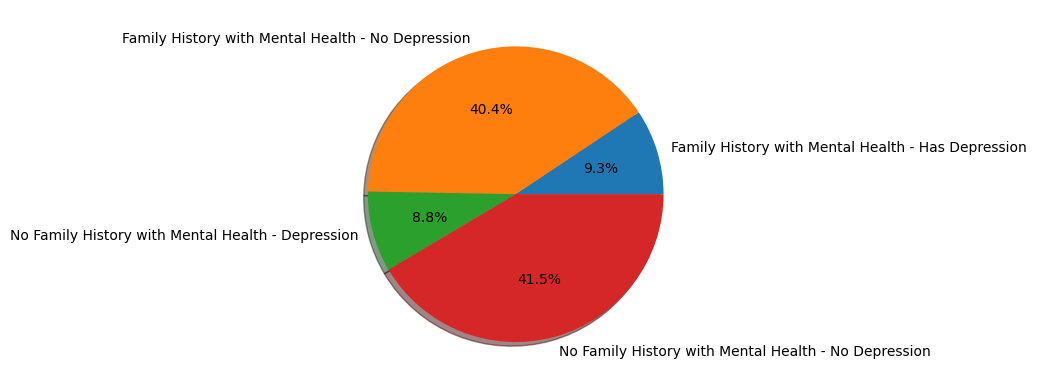

In [83]:
family_hist_with_depression = train_df[(train_df["Depression"] == 1) & (train_df["Family History of Mental Illness"] == "Yes")].shape[0]
family_hist_without_depression = train_df[(train_df["Depression"] == 0) & (train_df["Family History of Mental Illness"] == "Yes")].shape[0]
no_family_hist_with_depression = train_df[(train_df["Depression"] == 1) & (train_df["Family History of Mental Illness"] == "No")].shape[0]
no_family_hist_without_depression = train_df[(train_df["Depression"] == 0) & (train_df["Family History of Mental Illness"] == "No")].shape[0]

values = [family_hist_with_depression, family_hist_without_depression, no_family_hist_with_depression, no_family_hist_without_depression]
labels = ["Family History with Mental Health - Has Depression", "Family History with Mental Health - No Depression", "No Family History with Mental Health - Depression", "No Family History with Mental Health - No Depression"]

plt.pie(values, labels=labels, shadow=True, autopct='%1.1f%%')
plt.show()

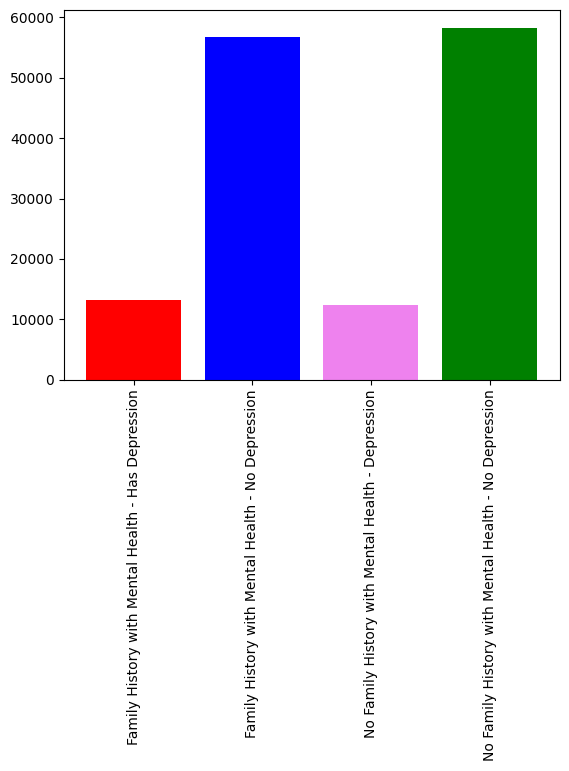

In [84]:
plt.bar(labels, values, color=["red", "blue", "violet", "green"])
plt.xticks(rotation=90)
plt.show()

Analysis of the **pie chart and bar chart** suggests that **family history of mental illness does not exhibit a strong association with depression** in this dataset.

Key observations:

- Among individuals **without depression**:
  - **40.4%** have a family history of mental illness.
  - **41.5%** do **not** have a family history — indicating a nearly equal distribution.
- Among individuals **with depression**:
  - **9.3%** have a family history of mental illness.
  - **8.8%** do not have a family history.

These proportions are **very close**, implying that having a family history of mental illness does **not significantly increase the likelihood of depression** in this sample.

**Conclusion:**  
Although family history is often considered a risk factor for mental health conditions, this dataset does **not provide strong evidence** of a substantial impact. The **prevalence of depression is almost equally distributed** regardless of family mental health history, suggesting other factors (e.g., financial stress, work pressure) may play a more prominent role.


In [85]:
train_df["Have you ever had suicidal thoughts ?"].unique()

array(['No', 'Yes'], dtype=object)

In [86]:
test_df["Have you ever had suicidal thoughts ?"].unique()

array(['No', 'Yes'], dtype=object)

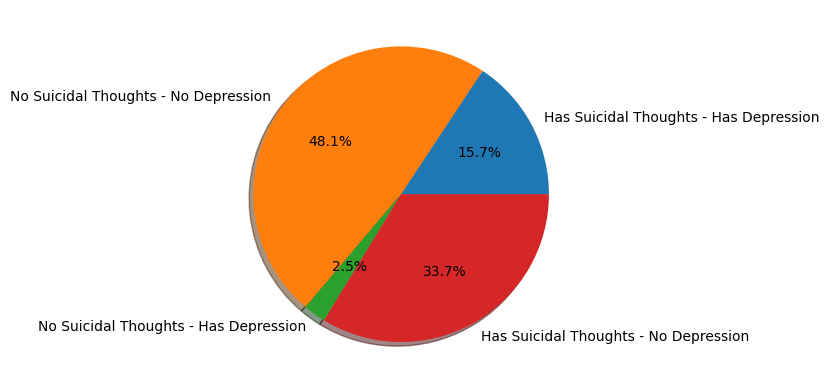

In [87]:
suicidal_with_depression = train_df[(train_df["Depression"] == 1) & (train_df["Have you ever had suicidal thoughts ?"] == "Yes")].shape[0]
not_suicidal_no_depression = train_df[(train_df["Depression"] == 0) & (train_df["Have you ever had suicidal thoughts ?"] == "No")].shape[0]
not_suicidal_with_depression = train_df[(train_df["Depression"] == 1) & (train_df["Have you ever had suicidal thoughts ?"] == "No")].shape[0]
suicidal_no_depression = train_df[(train_df["Depression"] == 0) & (train_df["Have you ever had suicidal thoughts ?"] == "Yes")].shape[0]

values = [suicidal_with_depression, not_suicidal_no_depression, not_suicidal_with_depression, suicidal_no_depression]
labels = ["Has Suicidal Thoughts - Has Depression", "No Suicidal Thoughts - No Depression", "No Suicidal Thoughts - Has Depression", "Has Suicidal Thoughts - No Depression"]

plt.pie(values, labels=labels, shadow=True, autopct='%1.1f%%')
plt.show()

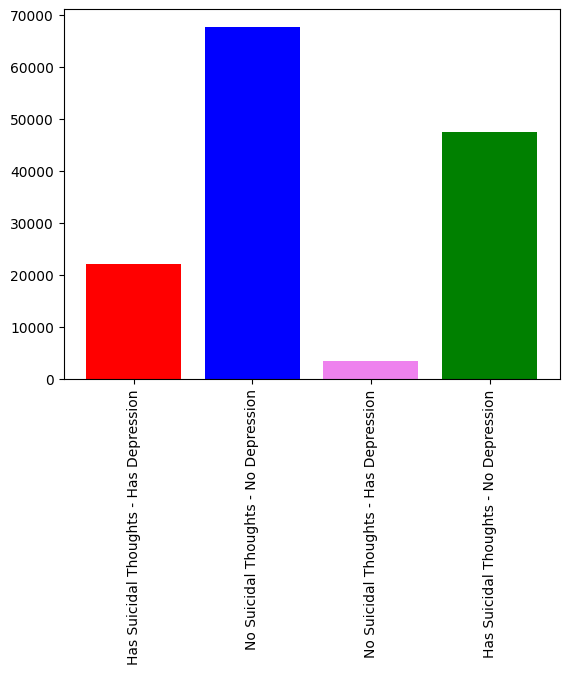

In [88]:
plt.bar(labels, values, color=["red", "blue", "violet", "green"])
plt.xticks(rotation=90)
plt.show()

The **bar chart** and **pie chart** indicate a **strong correlation between suicidal thoughts and depression**.

Key observations:

- Individuals who **experience suicidal thoughts** are **significantly more likely** to suffer from depression.
- In contrast, those who **do not report suicidal thoughts** show a **notably lower incidence** of depression.

This trend highlights the **critical impact of suicidal ideation** on mental health, emphasizing that suicidal thoughts are a **strong predictor or symptom** of underlying depression.

**Conclusion:**  
There is a **clear and concerning association** between suicidal thoughts and depression. This reinforces the importance of early intervention and mental health support for individuals expressing such thoughts, as they are at a **higher risk of experiencing clinical depression**.


In [89]:
train_df["Work/Study Hours"].unique()

array([ 1.,  7.,  3., 10.,  9.,  6.,  8.,  2.,  0.,  5., 12.,  4., 11.])

In [90]:
test_df["Work/Study Hours"].unique()

array([ 9.,  6., 12., 10.,  3.,  0.,  8.,  5.,  4., 11.,  7.,  1.,  2.])

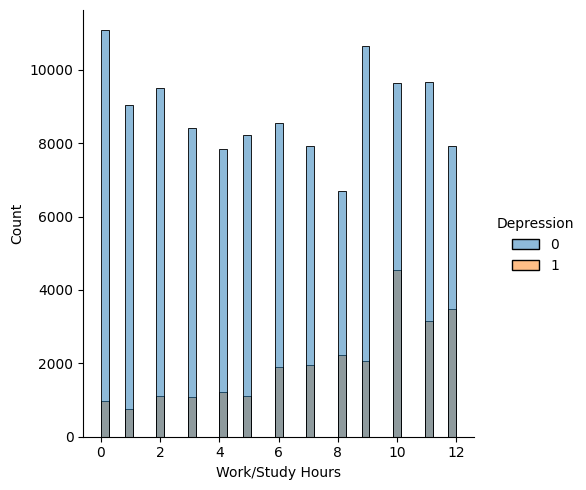

In [91]:
sns.displot(data=train_df, x=train_df["Work/Study Hours"], hue=train_df.Depression)
plt.show()

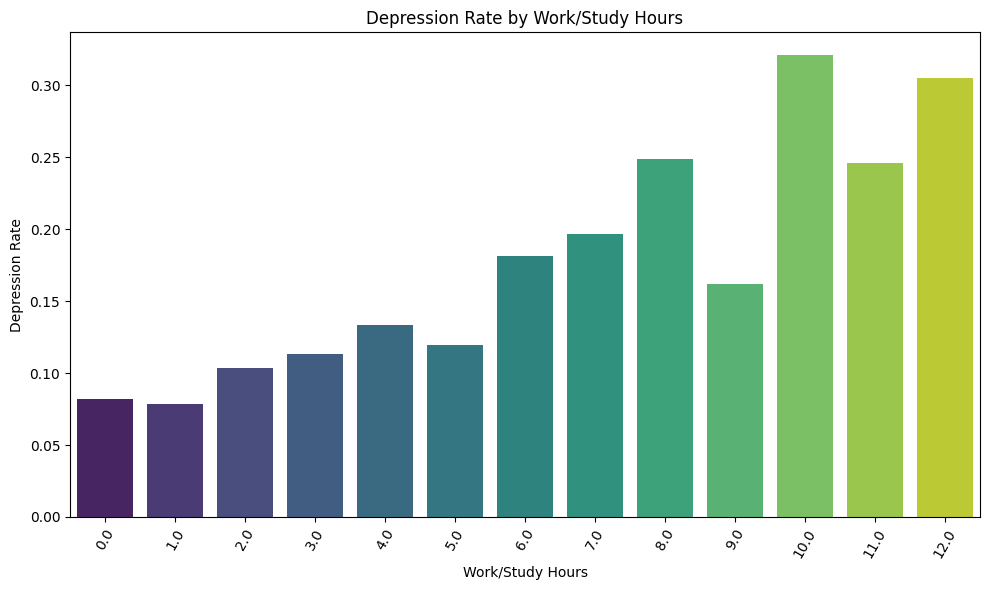

In [92]:
work_duration_depression = train_df.groupby("Work/Study Hours")["Depression"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=work_duration_depression.index, y=work_duration_depression.values, palette="viridis")
plt.xticks(rotation=60)
plt.ylabel("Depression Rate")
plt.title("Depression Rate by Work/Study Hours")
plt.tight_layout()
plt.show()

The graphs suggest a **positive correlation between workload (work/study hours) and depression levels**.

Key observations:

- Individuals who **study or work for longer hours** are **more likely to experience symptoms of depression**.
- As the number of hours dedicated to professional or academic responsibilities increases, so does the **incidence of reported depression**.

This trend highlights the potential **mental health risks associated with excessive workload**, indicating that **prolonged exposure to academic or professional pressure** may contribute to higher depression rates.

**Conclusion:**  
People who are heavily burdened with work or academic responsibilities are at an **elevated risk of depression**. This emphasizes the importance of promoting **work-life balance** and **stress management strategies** in both academic and professional environments.


In [93]:
train_df.CGPA.isnull().sum()

112776

In [94]:
test_df.CGPA.isnull().sum()

75034

In [95]:
train_df[(train_df.CGPA.isnull()) & (train_df["Working Professional or Student"] == "Student")].shape

(2, 15)

In [96]:
test_df[(test_df.CGPA.isnull()) & (test_df["Working Professional or Student"] == "Student")].shape

(9, 14)

In [97]:
mean_cgpa_students = train_df.loc[train_df["Working Professional or Student"] == "Student","CGPA"].mean()
train_df.loc[(train_df["CGPA"].isnull()) & (train_df["Working Professional or Student"] == "Student"), "CGPA"] = mean_cgpa_students
test_df.loc[(test_df["CGPA"].isnull()) & (test_df["Working Professional or Student"] == "Student"), "CGPA"] = mean_cgpa_students

In [98]:
train_df[(train_df.CGPA.isnull()) & (train_df["Working Professional or Student"] == "Student")].shape

(0, 15)

In [99]:
test_df[(test_df.CGPA.isnull()) & (test_df["Working Professional or Student"] == "Student")].shape

(0, 14)

In [100]:
train_df.CGPA.fillna(0, inplace=True)
test_df.CGPA.fillna(0, inplace=True)

In [101]:
train_df.CGPA.isnull().sum()

0

In [102]:
test_df.CGPA.isnull().sum()

0

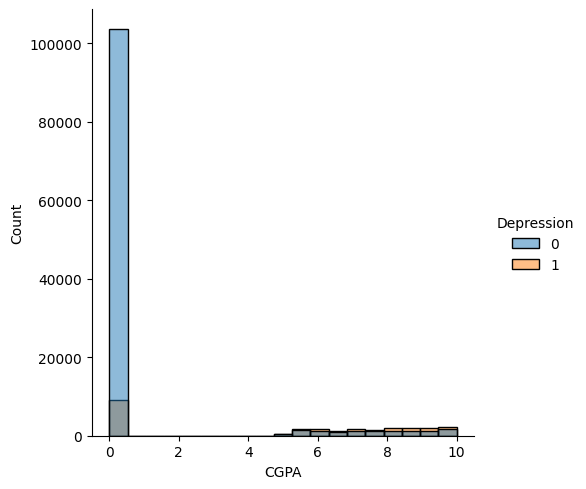

In [103]:
sns.displot(data=train_df, x=train_df.CGPA, hue=train_df.Depression)

In [104]:
student_df = train_df[train_df["Working Professional or Student"] == "Student"]

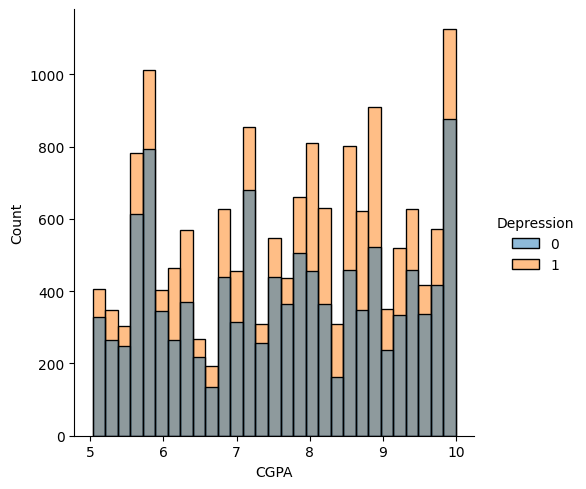

In [105]:
sns.displot(data=student_df, x=student_df.CGPA, hue=student_df.Depression)
plt.show()

The graphs reveal a **non-linear relationship** between CGPA and depression levels among students.

Key observations:

- Students with **very high CGPAs** often face intense **academic pressure, perfectionism, or burnout**, contributing to higher levels of depression.
- On the other hand, students with **very low CGPAs** may experience **feelings of failure, low self-esteem, and academic stress**, which also correlate with elevated depression levels.
- Students with **moderate CGPAs** appear to report comparatively **lower levels of depression**.

**Conclusion:**  
Both academic overachievement and underperformance can be **stress-inducing factors** that increase the likelihood of depression. This suggests the need for **mental health support systems** targeted at both ends of the academic performance spectrum.


In [106]:
train_df.Degree.unique()

array(['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'BSc', 'ME', 'B.Arch',
       'BCA', 'BE', 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com', 'MHM', 'BA',
       'Class 12', 'M.Tech', 'PhD', 'M.Ed', 'MSc', 'B.Tech', 'LLM',
       'MBBS', 'M.Pharm', 'UX/UI Designer', 'MPA', 'BH', 'Nalini', 'BEd',
       'B.Sc', 'Veda', 'Bhopal', 'S.Tech', 'Degree', '20', 'Class 11',
       'H_Pharm', 'M', 'P.Com', 'BPharm', 'Business Analyst', 'M.Arch',
       'LL.Com', 'Data Scientist', 'MPharm', 'L.Ed', 'P.Pharm', 'Kalyan',
       'Unite', 'BArch', 'HR Manager', 'Badhya', 'S.Pharm', 'LLBA',
       'Vrinda', 'M. Business Analyst', 'Bhavesh', '0', 'LLCom', '29',
       'MTech', 'Vivaan', 'BPA', 'Plumber', '5.61', 'Brit', 'B.03',
       'Ritik', '5.56', 'MEd', 'B', 'B BA', '7.06', 'B.B.Arch', 'ACA',
       'Brithika', 'CGPA', '24', 'M_Tech', 'Pihu', 'BB', 'Jhanvi',
       'LLTech', 'Aarav', 'Entrepreneur', '8.56', 'LHM', 'Lata', 'S.Arch',
       'Marsh', 'HCA', '5.88', 'B.Student', 'LL B.Ed', 'M.S', 'Navya',
   

In [107]:
test_df.Degree.unique()

array(['LLB', 'B.Ed', 'B.Arch', 'BSc', 'BCA', 'B.Com', 'MA', 'BA', 'BBA',
       'Class 12', 'MD', 'MBA', 'M.Ed', 'M.Pharm', 'BHM', 'LLM', 'PhD',
       'M.Com', 'BE', 'MBBS', 'B.Tech', 'ME', 'MCA', 'B.Pharm', 'MHM',
       'M.Tech', 'BTech', 'MSc', 'BArch', 'B. Gender', 'B.Study_Hours',
       'Advait', 'M.Arch', 'A.Ed', 'Mechanical Engineer', 'B.H', 'B.Sc',
       'B', 'M.UI', 'Vibha', 'B BCA', 'B.Press', 'BPharm', 'Gagan',
       'MPharm', 'Travel Consultant', '5.65', 'Business Analyst',
       'Eshita', 'B_Com', 'Navya', 'B._Pharm', 'Pune', 'Bian', 'B.M.Com',
       'Kavya', 'M.M.Ed', 'S.Pharm', 'Vrinda', 'M', 'E.Ed', '3.0',
       'Moham', 'B.BA', nan, 'I.Ed', 'Degree', 'Magan', 'B B.Tech',
       'M.B.Ed', 'Bhopal', 'B Financial Analyst', 'GCA', 'G.Ed', 'Rupak',
       'RCA', 'B.CA', 'PCA', 'J.Ed', 'BH', 'BEd', '8.95', 'Aadhya', '20',
       'Banchal', 'M.', 'K.Ed', 'BHCA'], dtype=object)

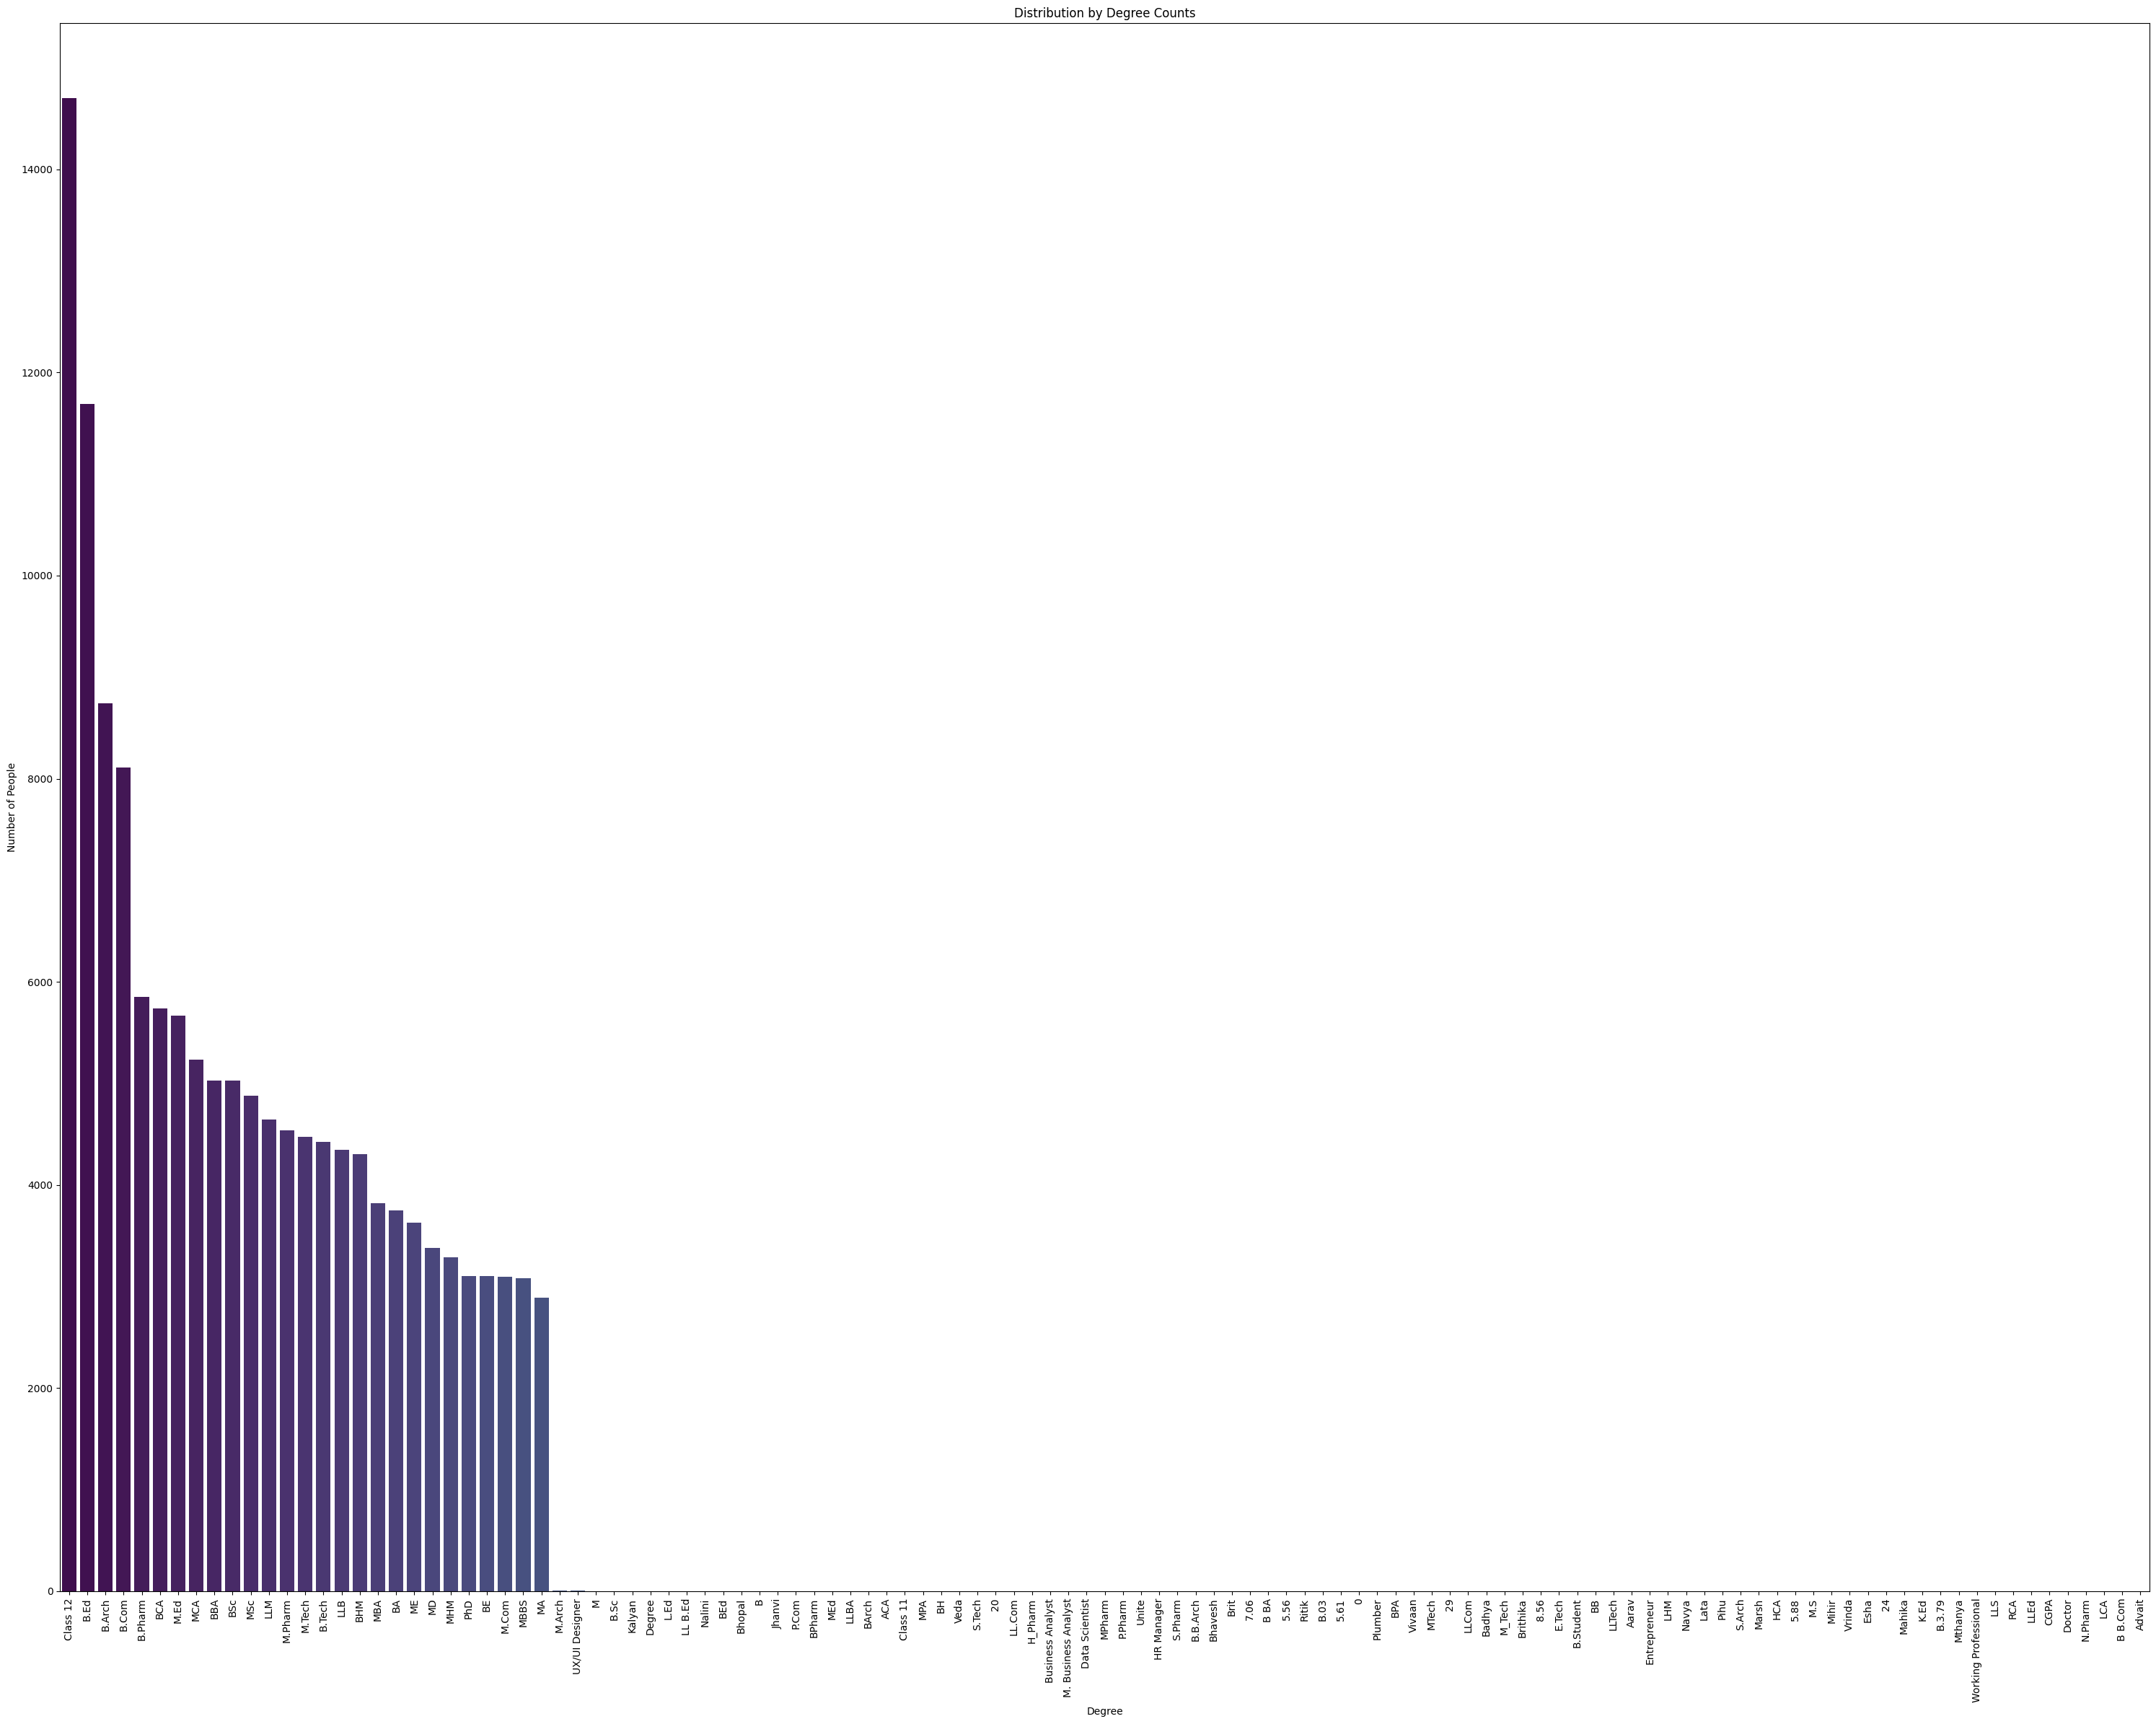

In [108]:
degree_counts = train_df.Degree.value_counts().sort_values(ascending=False)

plt.figure(figsize=(30, 24))
sns.barplot(x=degree_counts.index, y=degree_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Number of People")
plt.title("Distribution by Degree Counts")
plt.tight_layout()
plt.show()

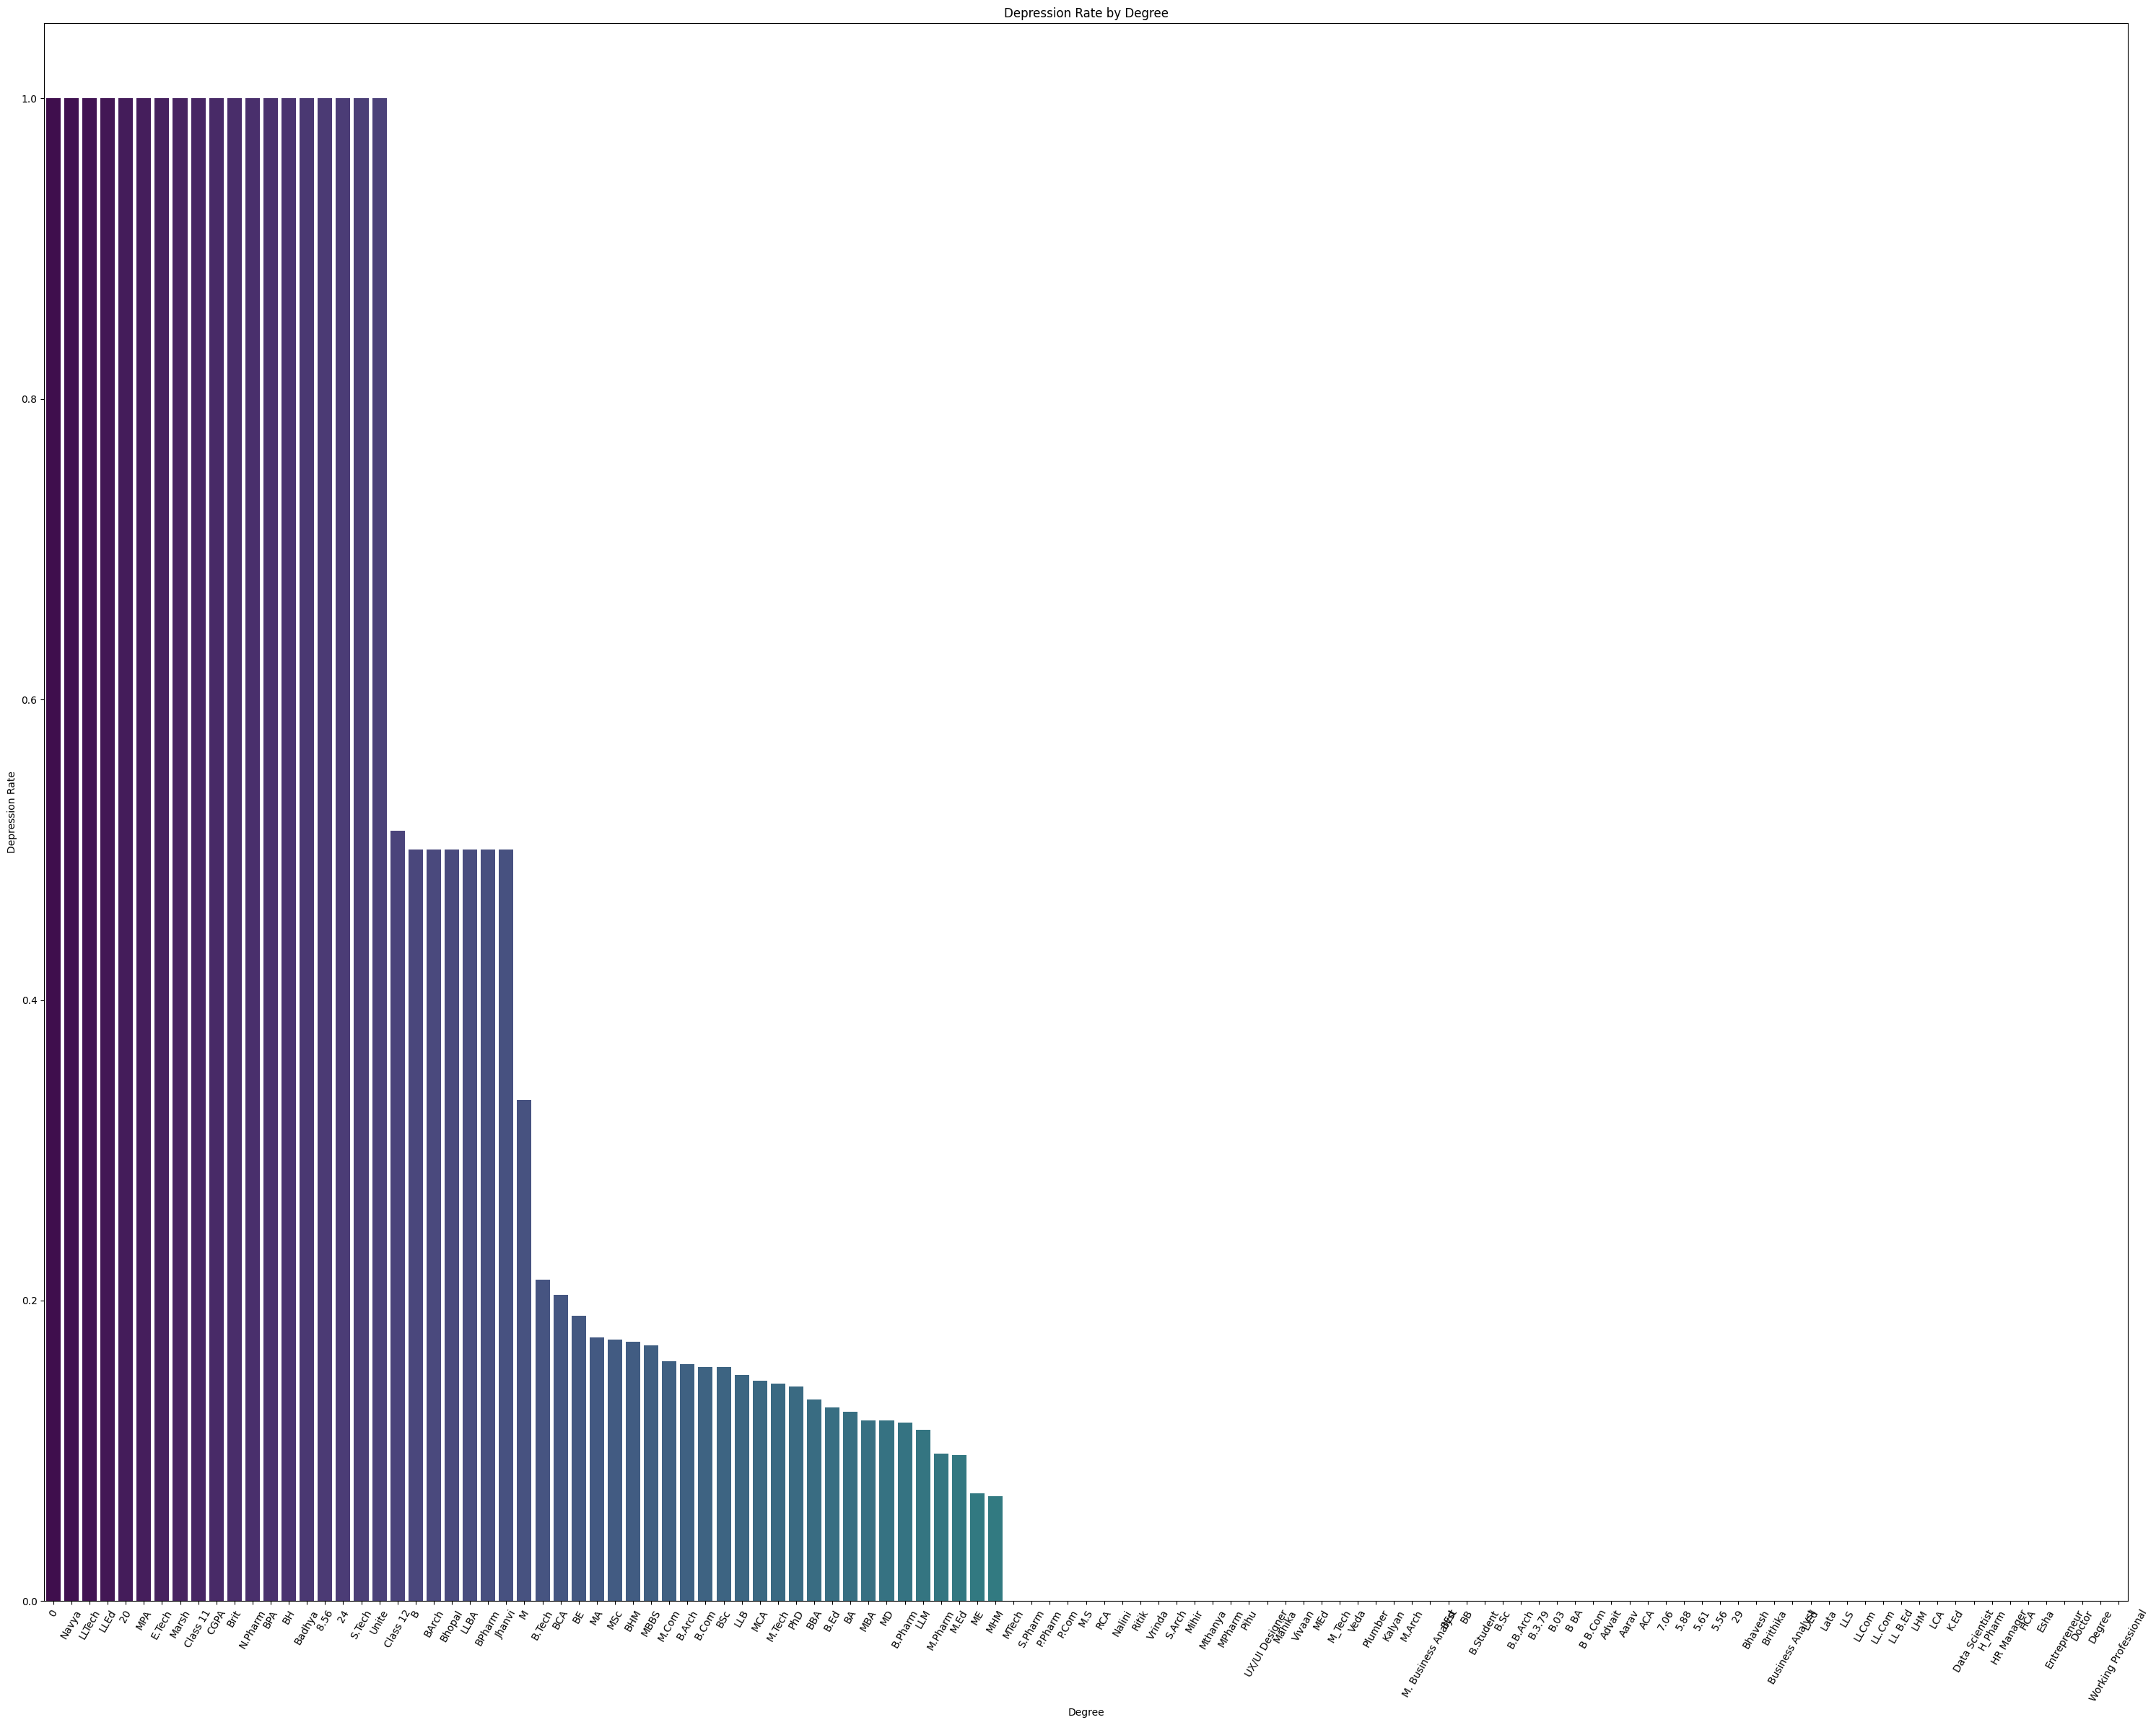

In [109]:
degree_depression = train_df.groupby("Degree")["Depression"].mean().sort_values(ascending=False)
plt.figure(figsize=(30, 24))
sns.barplot(x=degree_depression.index, y=degree_depression.values, palette="viridis")
plt.xticks(rotation=60)
plt.ylabel("Depression Rate")
plt.title("Depression Rate by Degree")
plt.tight_layout()
plt.show()

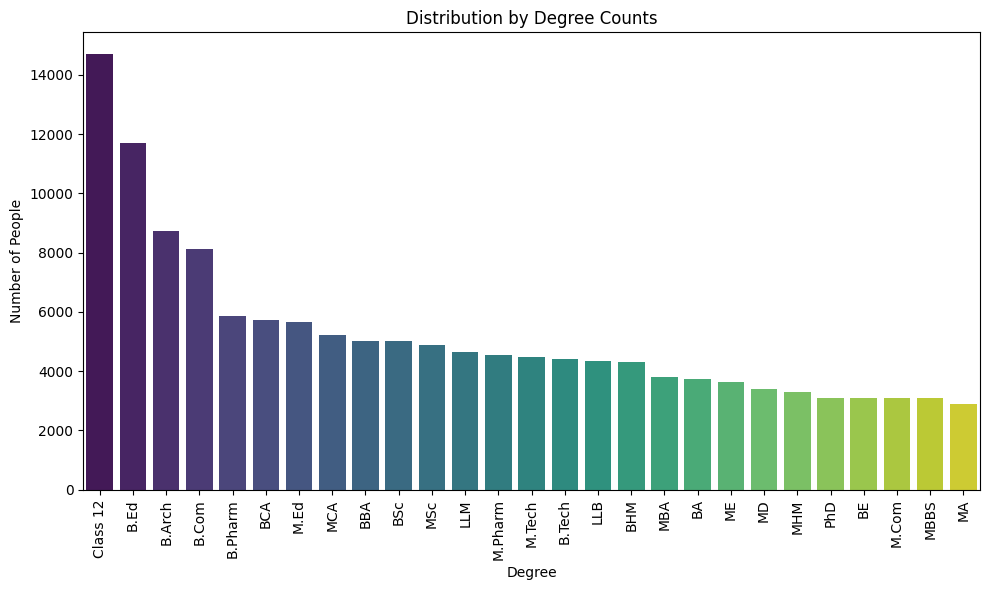

In [110]:
degree_counts = train_df.Degree.value_counts().sort_values(ascending=False)
degree_counts = degree_counts[degree_counts.values > 2000]
plt.figure(figsize=(10, 6))
sns.barplot(x=degree_counts.index, y=degree_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Number of People")
plt.title("Distribution by Degree Counts")
plt.tight_layout()
plt.show()

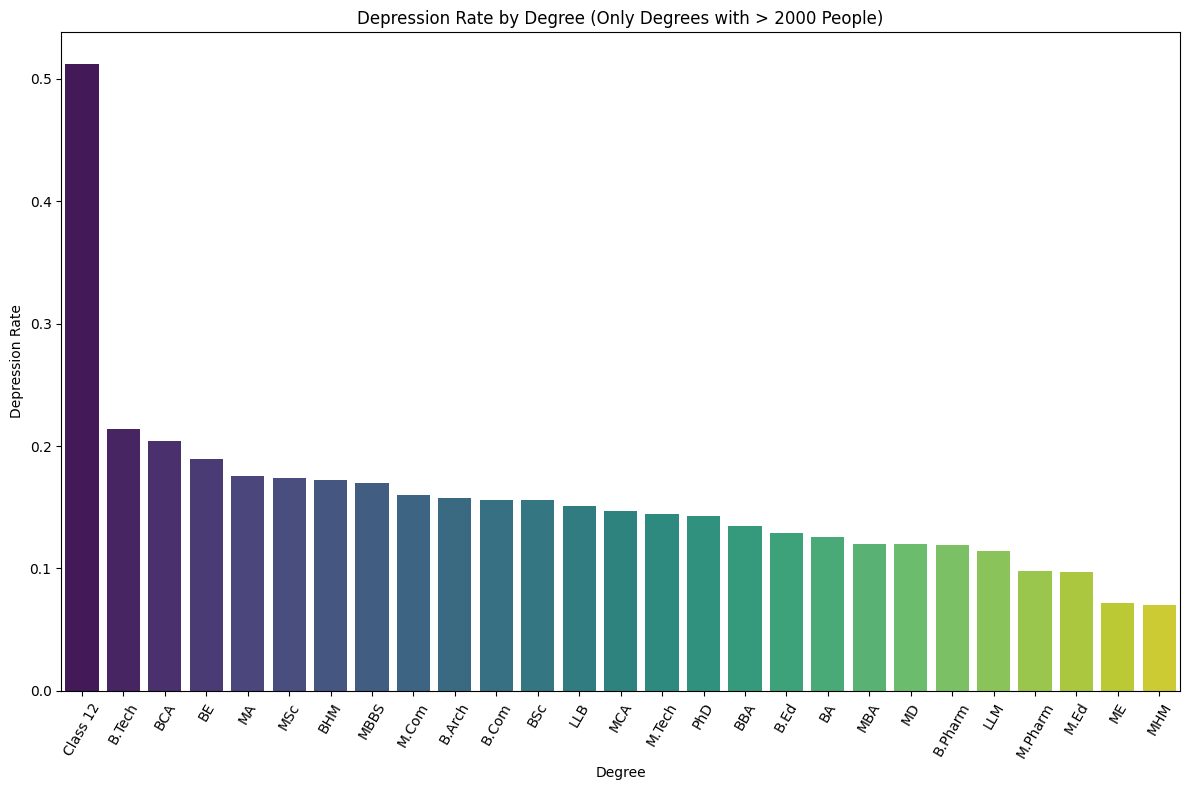

In [111]:
degree_depression = train_df[train_df["Degree"].isin(degree_counts.index)]
degree_depression = degree_depression.groupby("Degree")["Depression"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=degree_depression.index, y=degree_depression.values, palette="viridis")
plt.xticks(rotation=60)
plt.ylabel("Depression Rate")
plt.title("Depression Rate by Degree (Only Degrees with > 2000 People)")
plt.tight_layout()
plt.show()

In [112]:
train_df.dropna(subset=["Degree"], inplace=True)

In [113]:
train_df[(train_df["Working Professional or Student"] == "Student") & (train_df.Degree == "Class 12")]["Depression"].value_counts()

Depression
1    4297
0    1773
Name: count, dtype: int64

In [114]:
train_df[(train_df["Working Professional or Student"] == "Working Professional") & (train_df.Degree == "Class 12")]["Depression"].value_counts()

Depression
0    5395
1    3237
Name: count, dtype: int64

The analysis reveals that individuals currently enrolled in Class 12 or those who have completed their education up to Class 12 and are now working exhibit a higher susceptibility to depression. Among degrees with more than 2000 occurrences, the depression rates appear relatively uniform, suggesting minimal variation across popular degree categories. Furthermore, several degrees have negligible representation in the dataset, making them statistically insignificant for analysis.

To streamline the analysis and extract more meaningful insights, I will introduce a new column titled **"Currently in College or Studied till College Only"**. This derived feature will help capture the educational exposure more clearly. Following this, the original **Degree** column will be dropped, as it offers limited discriminative power in its current form.


In [115]:
def CreateCollegeColumn(row):
    if row["Degree"] == "Class 12":
        return 1
    return 0

train_df["Currently in College or Studied till College Only"] = train_df.apply(CreateCollegeColumn, axis=1)
test_df["Currently in College or Studied till College Only"] = test_df.apply(CreateCollegeColumn, axis=1)

In [116]:
train_df.drop(columns=["Degree"], inplace=True)
test_df.drop(columns=["Degree"], inplace=True)

In [117]:
train_df.Profession.unique()

array(['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst',
       'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist',
       'Plumber', 'Marketing Manager', 'Accountant', 'Entrepreneur',
       'HR Manager', 'UX/UI Designer', 'Content Writer',
       'Educational Consultant', 'Civil Engineer', 'Manager',
       'Pharmacist', 'Financial Analyst', 'Architect',
       'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
       'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
       'Digital Marketer', 'Lawyer', 'Research Analyst',
       'Sales Executive', 'Doctor', 'Unemployed', 'Investment Banker',
       'Family Consultant', 'B.Com', 'BE', 'Student', 'Yogesh', 'Dev',
       'MBA', 'LLM', 'BCA', 'Academic', 'Profession', 'FamilyVirar',
       'City Manager', 'BBA', 'Medical Doctor', 'Working Professional',
       'MBBS', 'Patna', 'Unveil', 'B.Ed', 'Nagpur', 'Moderate', 'M.Ed',
       'Analyst', 'Pranav', 'Visakhapatnam', 'PhD', 'Yu

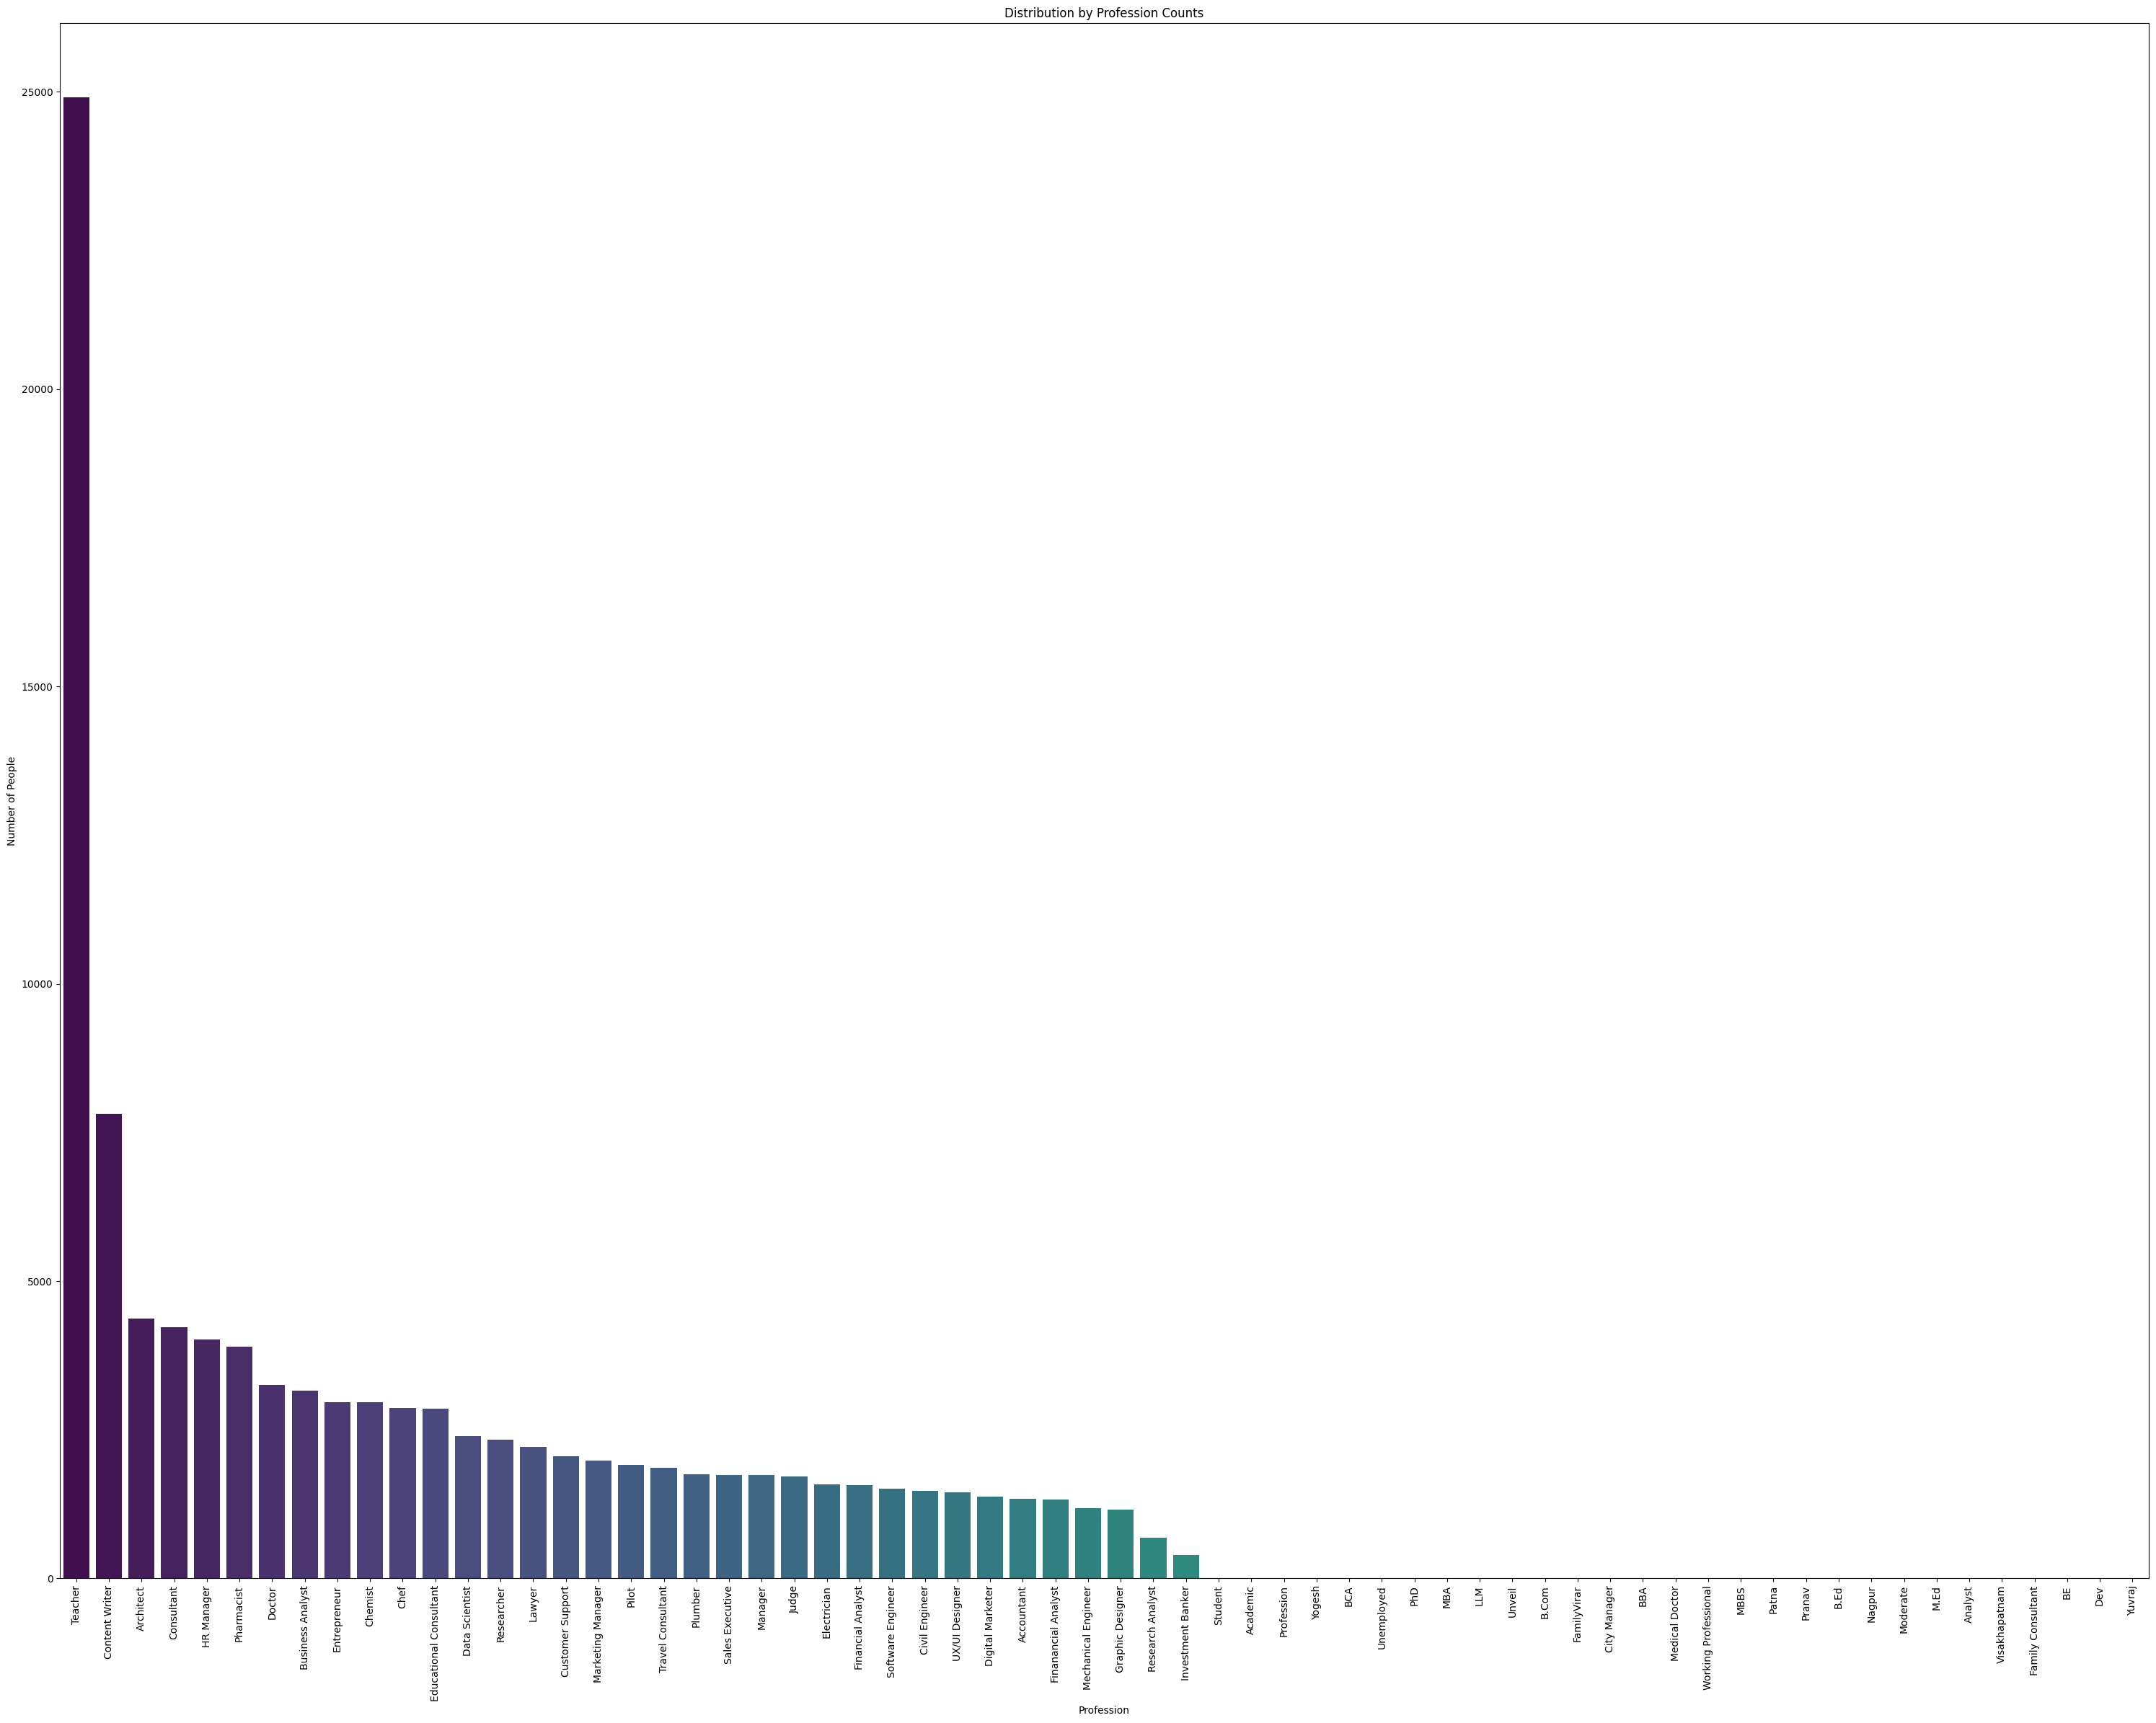

In [118]:
profession_counts = train_df.Profession.value_counts().sort_values(ascending=False)

plt.figure(figsize=(30, 24))
sns.barplot(x=profession_counts.index, y=profession_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Number of People")
plt.title("Distribution by Profession Counts")
plt.tight_layout()
plt.show()

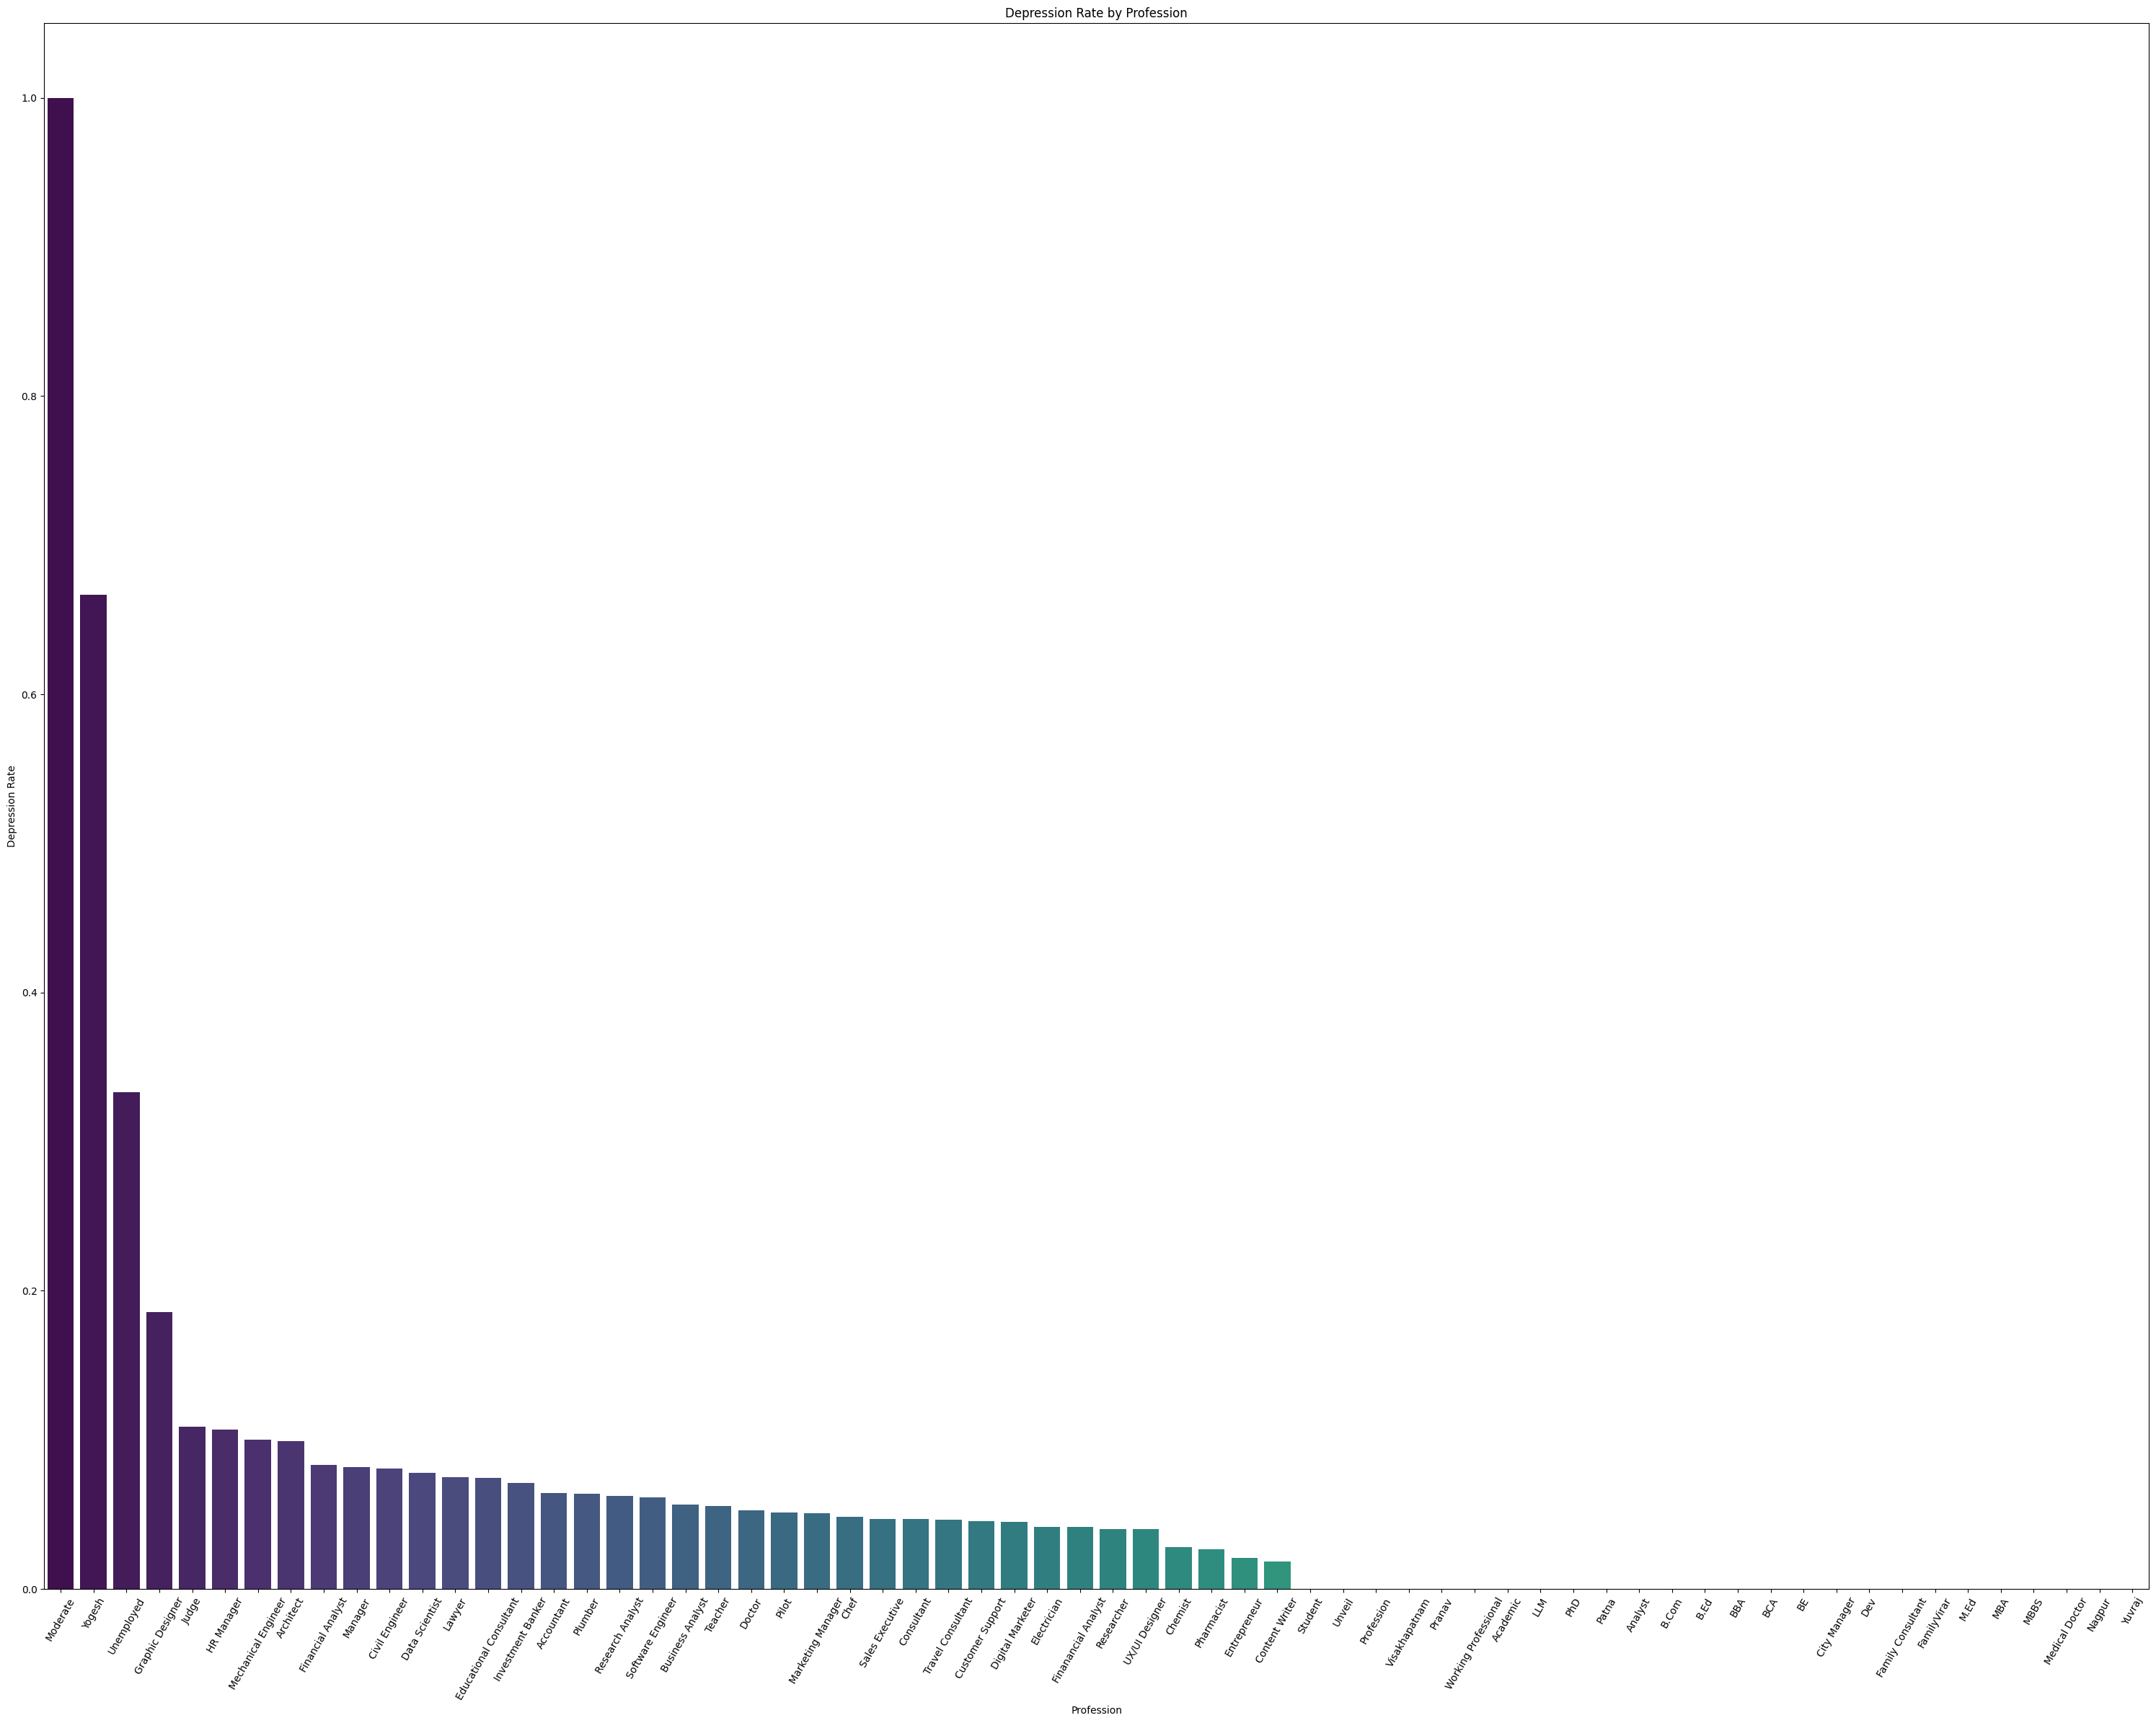

In [119]:
profession_depression = train_df.groupby("Profession")["Depression"].mean().sort_values(ascending=False)
plt.figure(figsize=(30, 24))
sns.barplot(x=profession_depression.index, y=profession_depression.values, palette="viridis")
plt.xticks(rotation=60)
plt.ylabel("Depression Rate")
plt.title("Depression Rate by Profession")
plt.tight_layout()
plt.show()

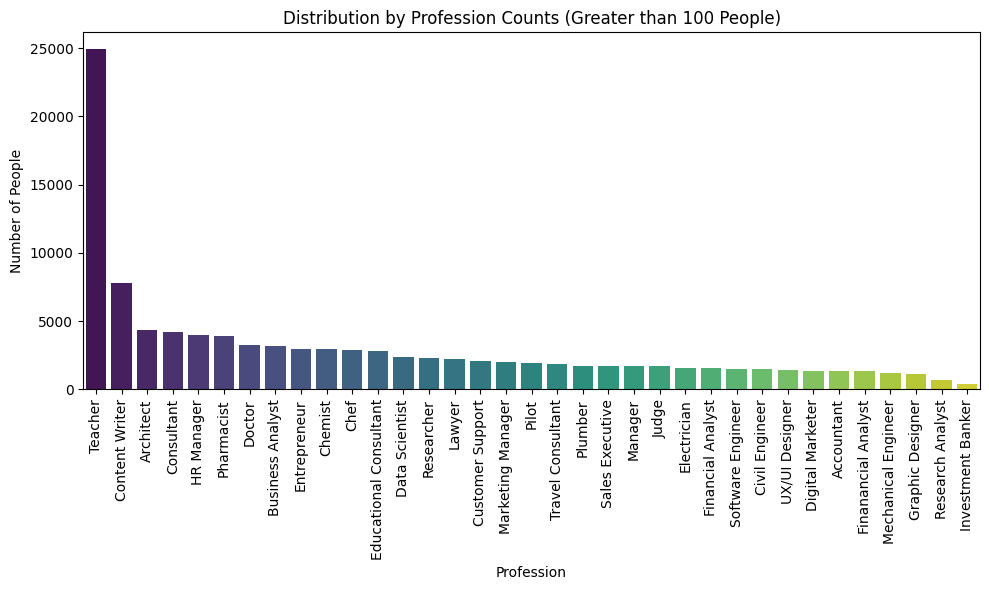

In [120]:
profession_counts = train_df.Profession.value_counts().sort_values(ascending=False)
profession_counts = profession_counts[profession_counts.values > 100]
plt.figure(figsize=(10, 6))
sns.barplot(x=profession_counts.index, y=profession_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Number of People")
plt.title("Distribution by Profession Counts (Greater than 100 People)")
plt.tight_layout()
plt.show()

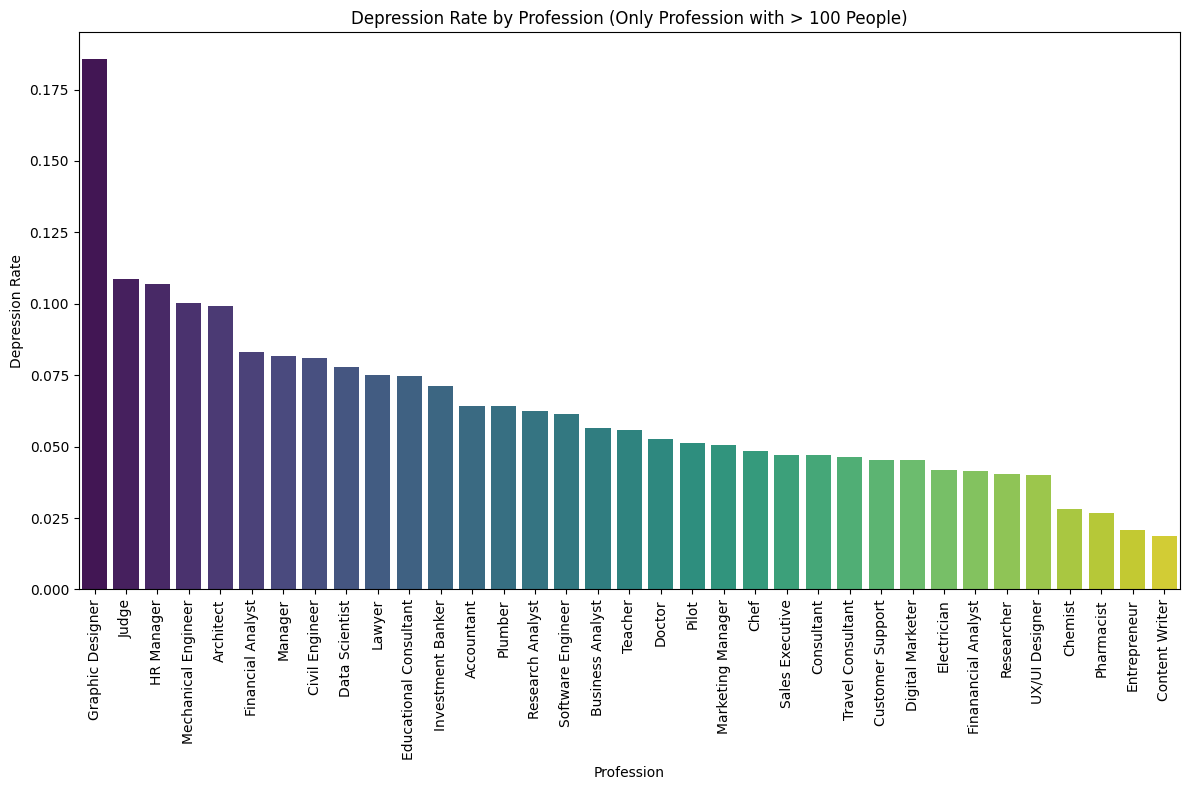

In [121]:
profession_depression = train_df[train_df["Profession"].isin(profession_counts.index)]
profession_depression = profession_depression.groupby("Profession")["Depression"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=profession_depression.index, y=profession_depression.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Depression Rate")
plt.title("Depression Rate by Profession (Only Profession with > 100 People)")
plt.tight_layout()
plt.show()

In [122]:
train_df[train_df.Profession == "Graphic Designer"].shape

(1163, 15)

The analysis shows that for professions with more than 100 individuals, the highest depression rate is approximately **0.175**, observed among **Graphic Designers**, a group comprising around **1,163 individuals**.

However, most other professions have a depression rate of **less than 0.1**, indicating a weak or negligible relationship between profession and depression. Additionally, many professions have very few data points, which makes their depression rates statistically unreliable.

Therefore, the **Profession** column does **not provide significant predictive power** and will be **dropped** from the dataset to streamline the analysis.


In [123]:
train_df.drop(columns=["Profession"], inplace=True)
test_df.drop(columns=["Profession"], inplace=True)

In [124]:
train_df.shape

(140661, 14)

In [125]:
test_df.shape

(93800, 13)

In [126]:
train_df['Dietary Habits'].unique()

array(['Healthy', 'Unhealthy', 'Moderate', 'Yes', 'Pratham', 'BSc',
       'Gender', '3', 'More Healthy', 'Less than Healthy', 'Mihir', '1.0',
       'Hormonal', 'Electrician', nan, 'No Healthy', 'Less Healthy',
       'M.Tech', 'Vegas', 'No', 'Male', 'Indoor', 'Class 12', '2'],
      dtype=object)

In [127]:
test_df['Dietary Habits'].unique()

array(['Moderate', 'Healthy', 'Unhealthy', 'More Healthy', 'No', 'Indoor',
       'Prachi', nan, 'Male', 'Less Healthy', 'Mealy', 'Resistant', 'MCA',
       '5 Healthy', 'Academic', 'Educational', 'Soham', '5 Unhealthy',
       'Vivaan', 'Raghav', '1.0', 'Naina', 'Kolkata'], dtype=object)

In [128]:
train_df['Dietary Habits'].replace("More Healthy", "Healthy", inplace=True)
train_df['Dietary Habits'].replace("Less than Healthy", "Moderate", inplace=True)
train_df['Dietary Habits'].replace("No Healthy", "Unhealthy", inplace=True)
train_df['Dietary Habits'].replace("Less Healthy", "Unhealthy", inplace=True)
train_df['Dietary Habits'].replace("5 Healthy", "Healthy", inplace=True)
train_df['Dietary Habits'].replace("5 Unhealthy", "Unhealthy", inplace=True)

test_df['Dietary Habits'].replace("More Healthy", "Healthy", inplace=True)
test_df['Dietary Habits'].replace("Less than Healthy", "Moderate", inplace=True)
test_df['Dietary Habits'].replace("No Healthy", "Unhealthy", inplace=True)
test_df['Dietary Habits'].replace("Less Healthy", "Unhealthy", inplace=True)
test_df['Dietary Habits'].replace("5 Healthy", "Healthy", inplace=True)
test_df['Dietary Habits'].replace("5 Unhealthy", "Unhealthy", inplace=True)

In [129]:
train_df['Dietary Habits'].unique()

array(['Healthy', 'Unhealthy', 'Moderate', 'Yes', 'Pratham', 'BSc',
       'Gender', '3', 'Mihir', '1.0', 'Hormonal', 'Electrician', nan,
       'M.Tech', 'Vegas', 'No', 'Male', 'Indoor', 'Class 12', '2'],
      dtype=object)

In [130]:
test_df['Dietary Habits'].unique()

array(['Moderate', 'Healthy', 'Unhealthy', 'No', 'Indoor', 'Prachi', nan,
       'Male', 'Mealy', 'Resistant', 'MCA', 'Academic', 'Educational',
       'Soham', 'Vivaan', 'Raghav', '1.0', 'Naina', 'Kolkata'],
      dtype=object)

In [131]:
allowed_values = ['Healthy', 'Unhealthy', 'Moderate']
train_df['Dietary Habits'] = train_df['Dietary Habits'].where(train_df['Dietary Habits'].isin(allowed_values), np.nan)
test_df['Dietary Habits'] = test_df['Dietary Habits'].where(test_df['Dietary Habits'].isin(allowed_values), np.nan)

In [132]:
train_df['Dietary Habits'].unique()

array(['Healthy', 'Unhealthy', 'Moderate', nan], dtype=object)

In [133]:
test_df['Dietary Habits'].unique()

array(['Moderate', 'Healthy', 'Unhealthy', nan], dtype=object)

I will use a **KNN Imputer** to fill these nan values

In [134]:
train_df["Sleep Duration"].unique()

array(['More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours',
       'Sleep_Duration', '1-2 hours', '6-8 hours', '4-6 hours',
       '6-7 hours', '10-11 hours', '8-9 hours', '40-45 hours',
       '9-11 hours', '2-3 hours', '3-4 hours', 'Moderate', '55-66 hours',
       '4-5 hours', '9-6 hours', '1-3 hours', 'Indore', '45', '1-6 hours',
       '35-36 hours', '8 hours', 'No', '10-6 hours', 'than 5 hours',
       '49 hours', 'Unhealthy', 'Work_Study_Hours', '3-6 hours',
       '45-48 hours', '9-5', 'Pune', '9-5 hours'], dtype=object)

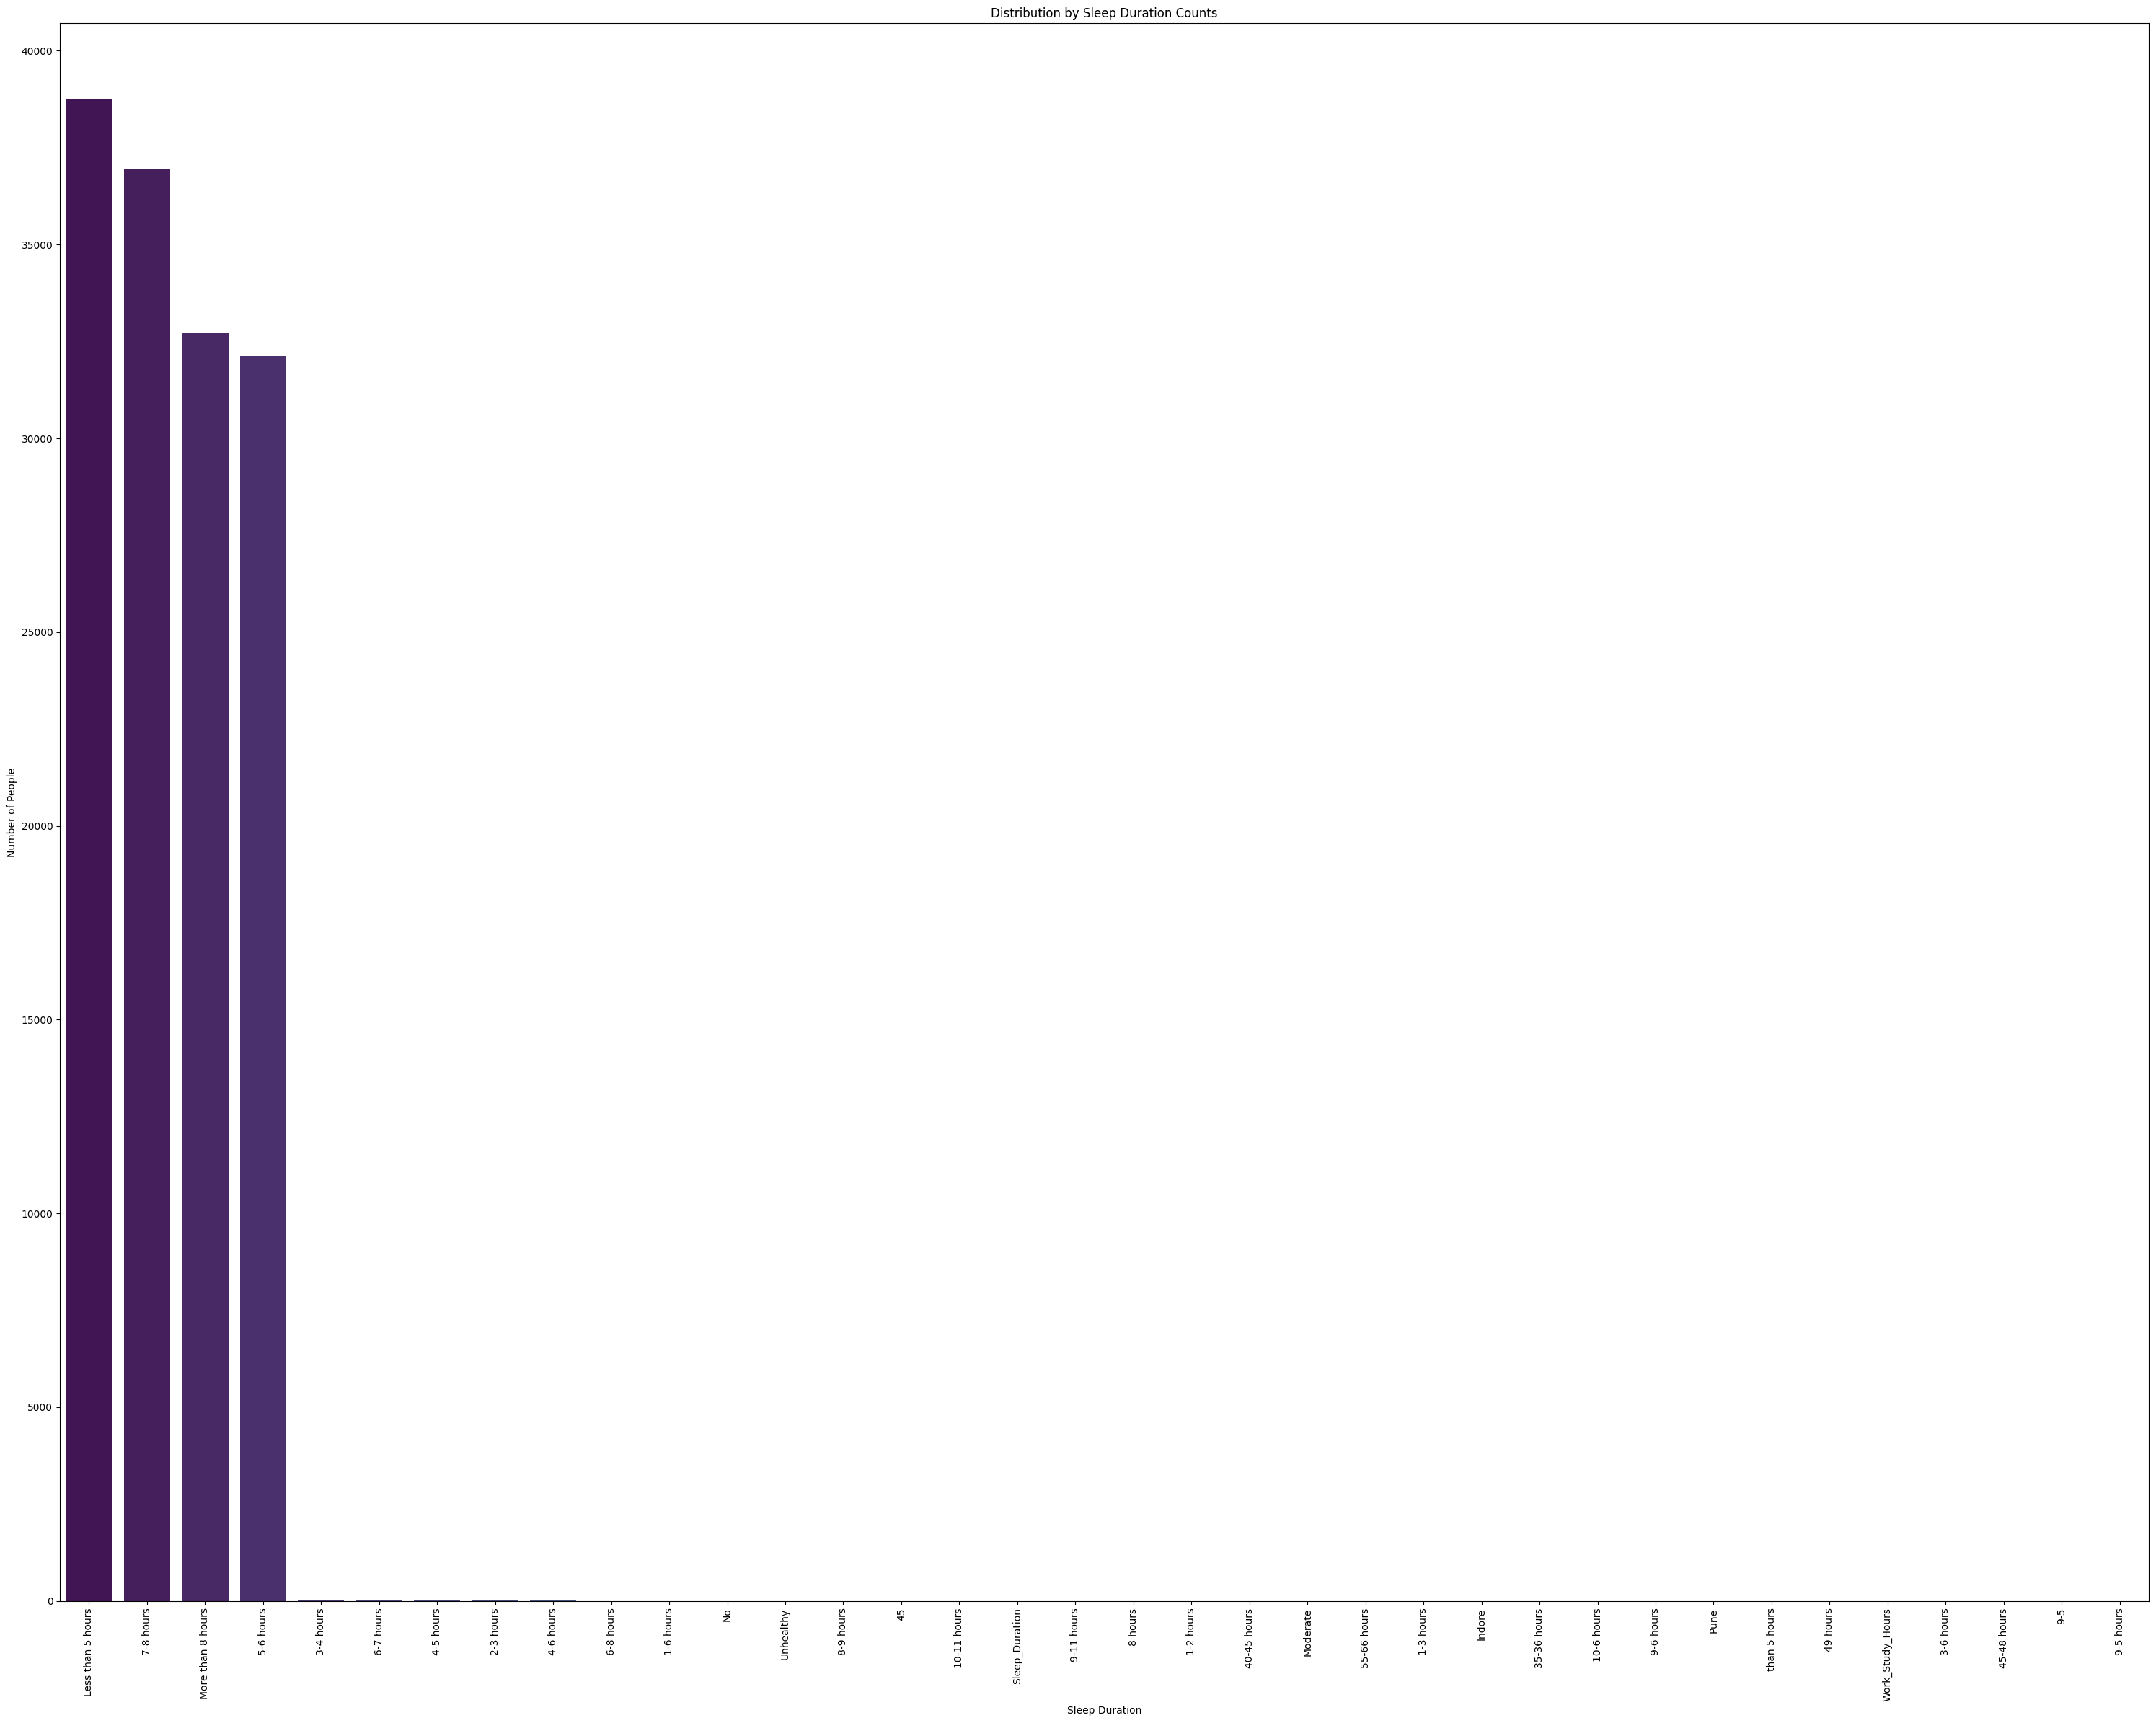

In [135]:
sleep_counts = train_df["Sleep Duration"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(30, 24))
sns.barplot(x=sleep_counts.index, y=sleep_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Number of People")
plt.title("Distribution by Sleep Duration Counts")
plt.tight_layout()
plt.show()

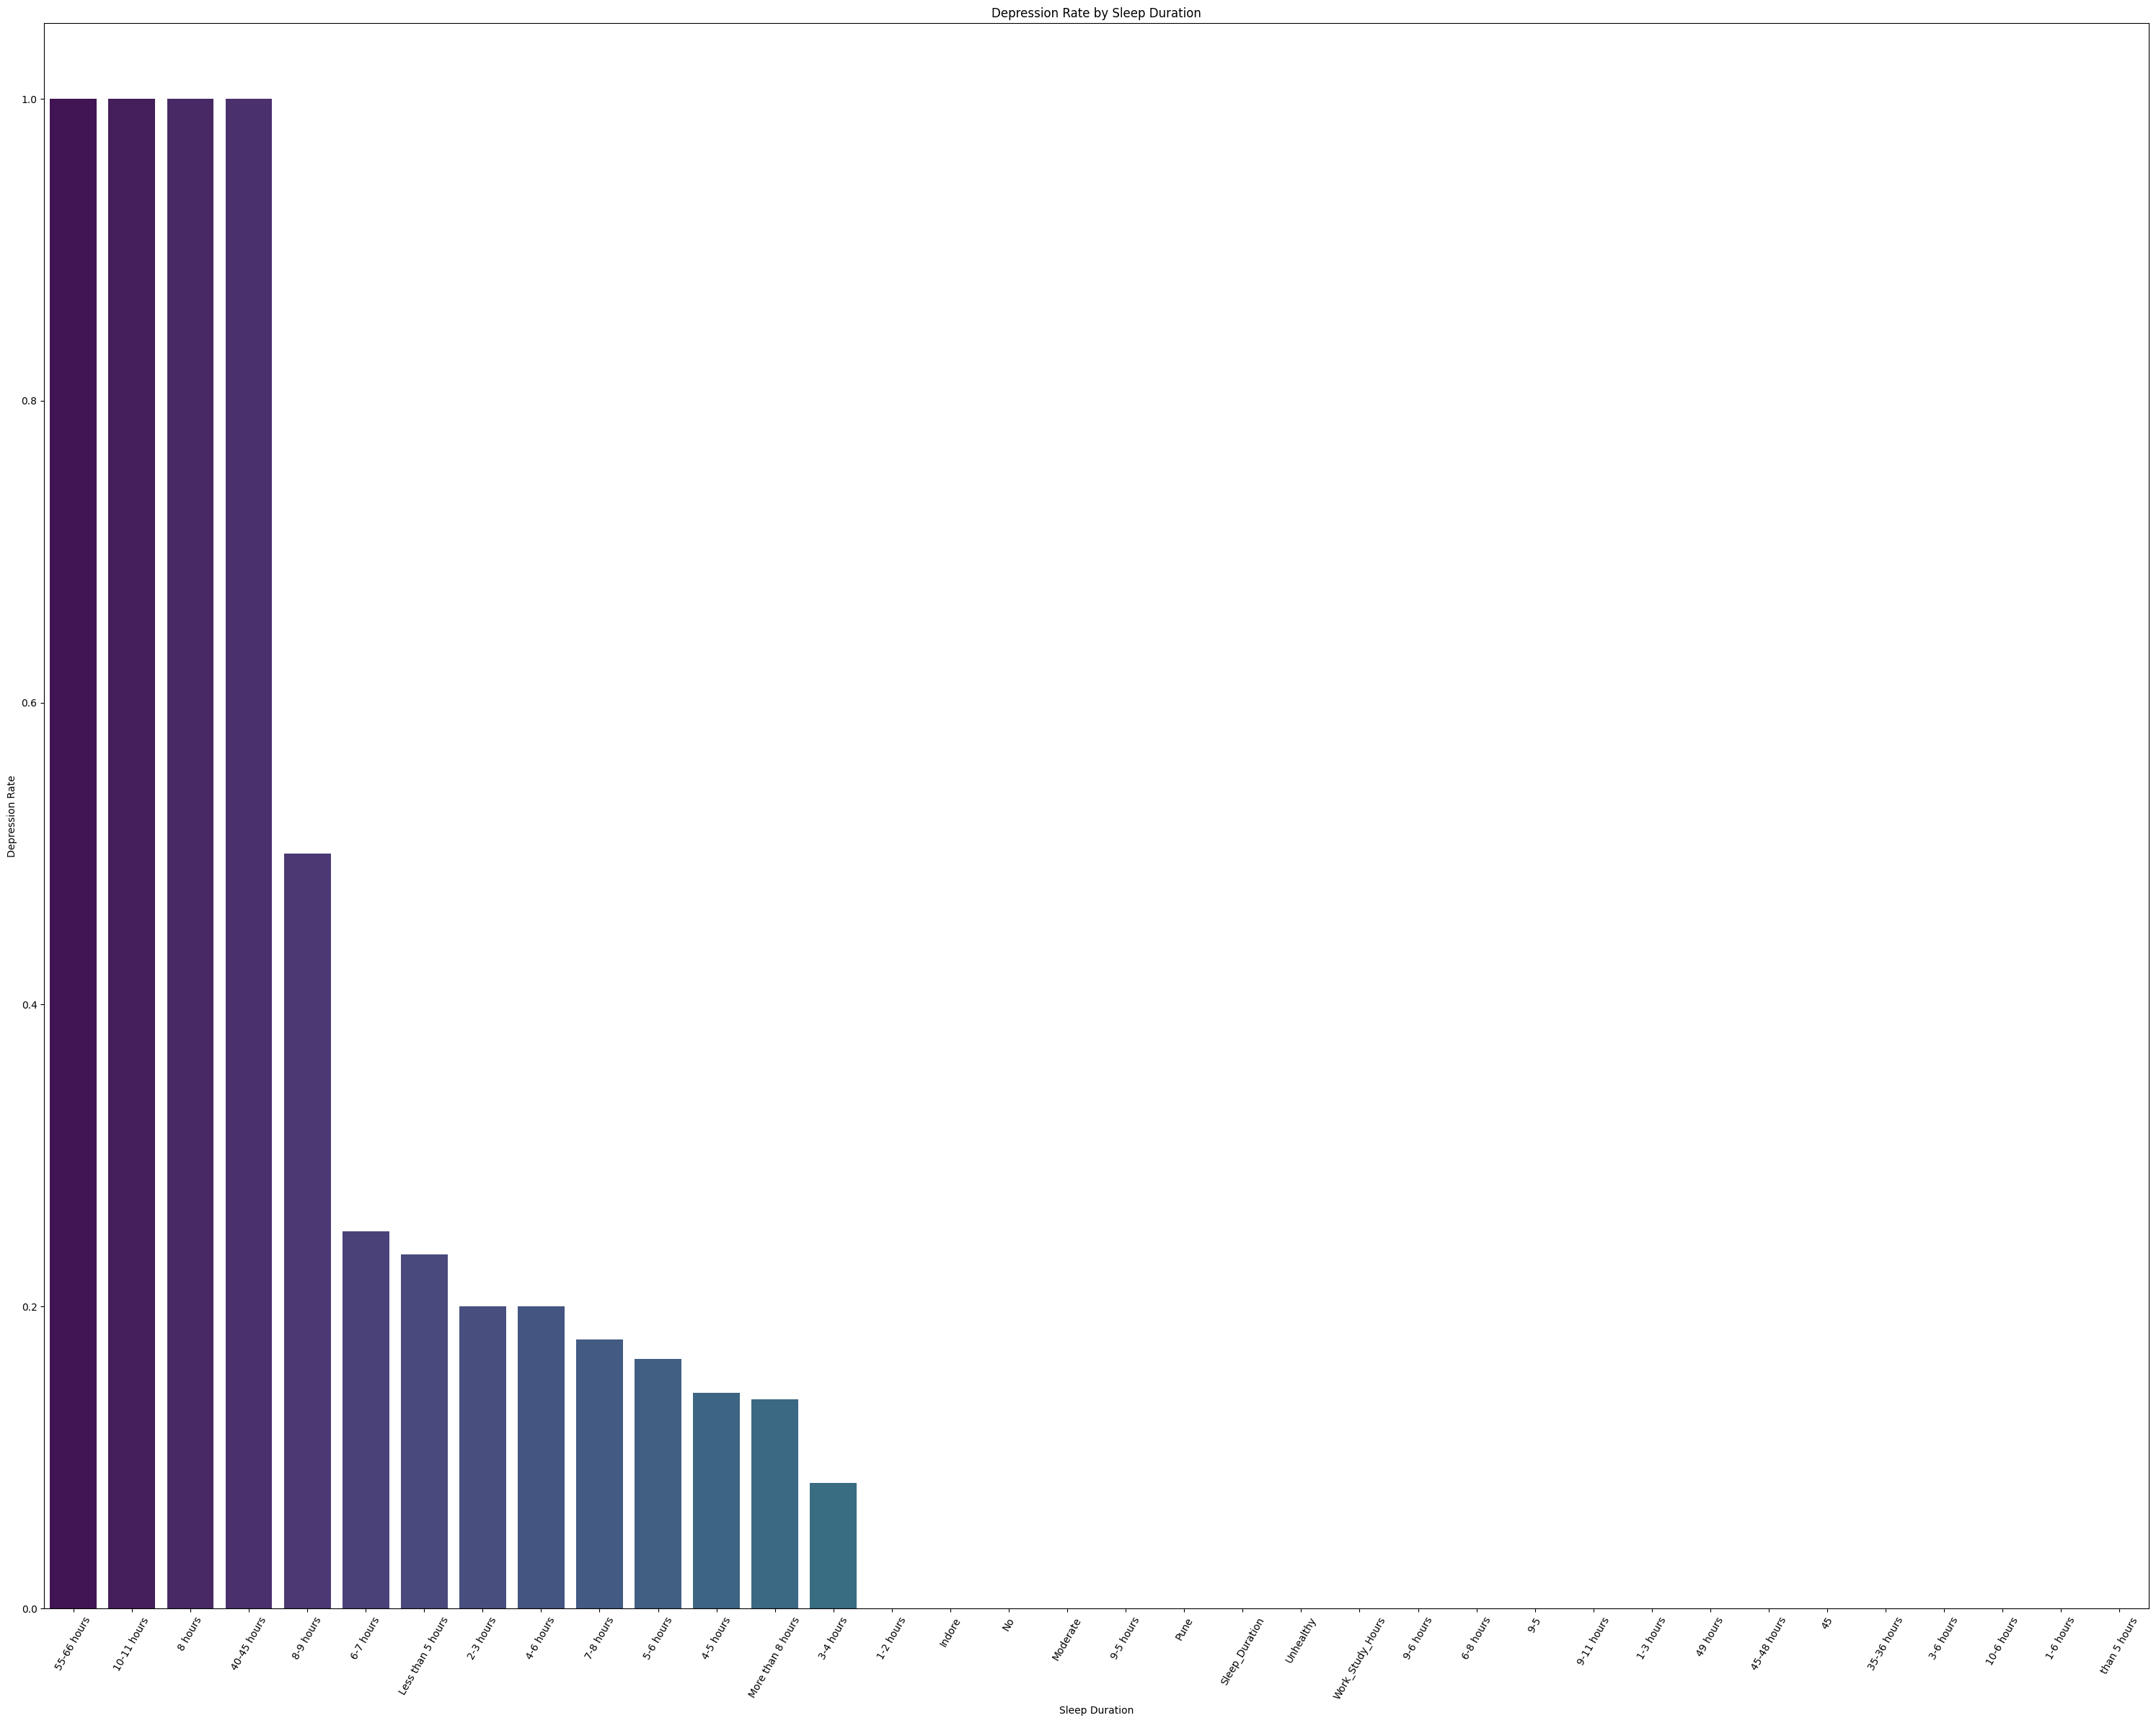

In [136]:
sleep_depression = train_df.groupby("Sleep Duration")["Depression"].mean().sort_values(ascending=False)
plt.figure(figsize=(30, 24))
sns.barplot(x=sleep_depression.index, y=sleep_depression.values, palette="viridis")
plt.xticks(rotation=60)
plt.ylabel("Depression Rate")
plt.title("Depression Rate by Sleep Duration")
plt.tight_layout()
plt.show()

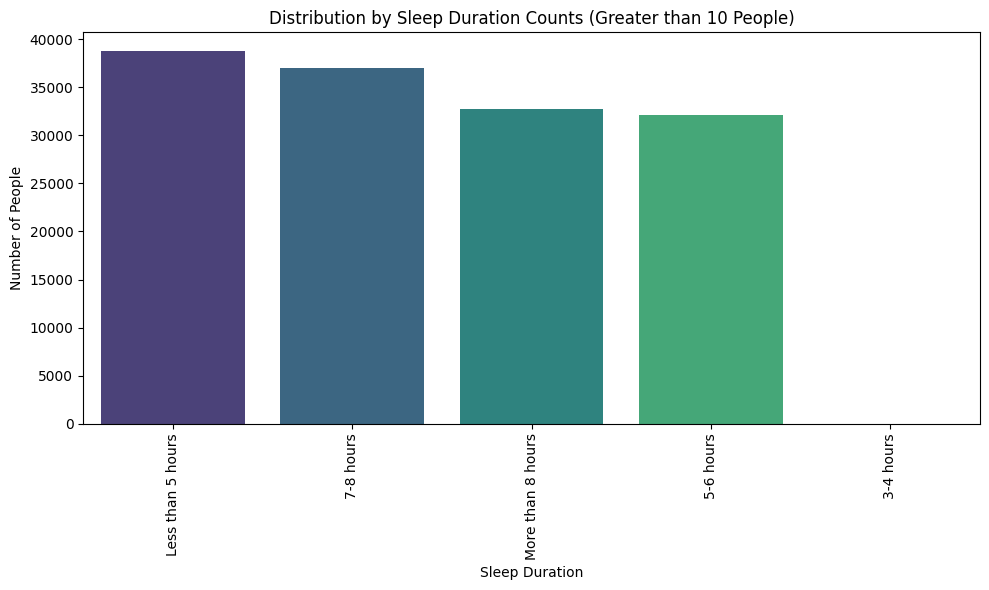

In [137]:
sleep_counts = train_df["Sleep Duration"].value_counts().sort_values(ascending=False)
sleep_counts = sleep_counts[sleep_counts.values > 10]
plt.figure(figsize=(10, 6))
sns.barplot(x=sleep_counts.index, y=sleep_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Number of People")
plt.title("Distribution by Sleep Duration Counts (Greater than 10 People)")
plt.tight_layout()
plt.show()

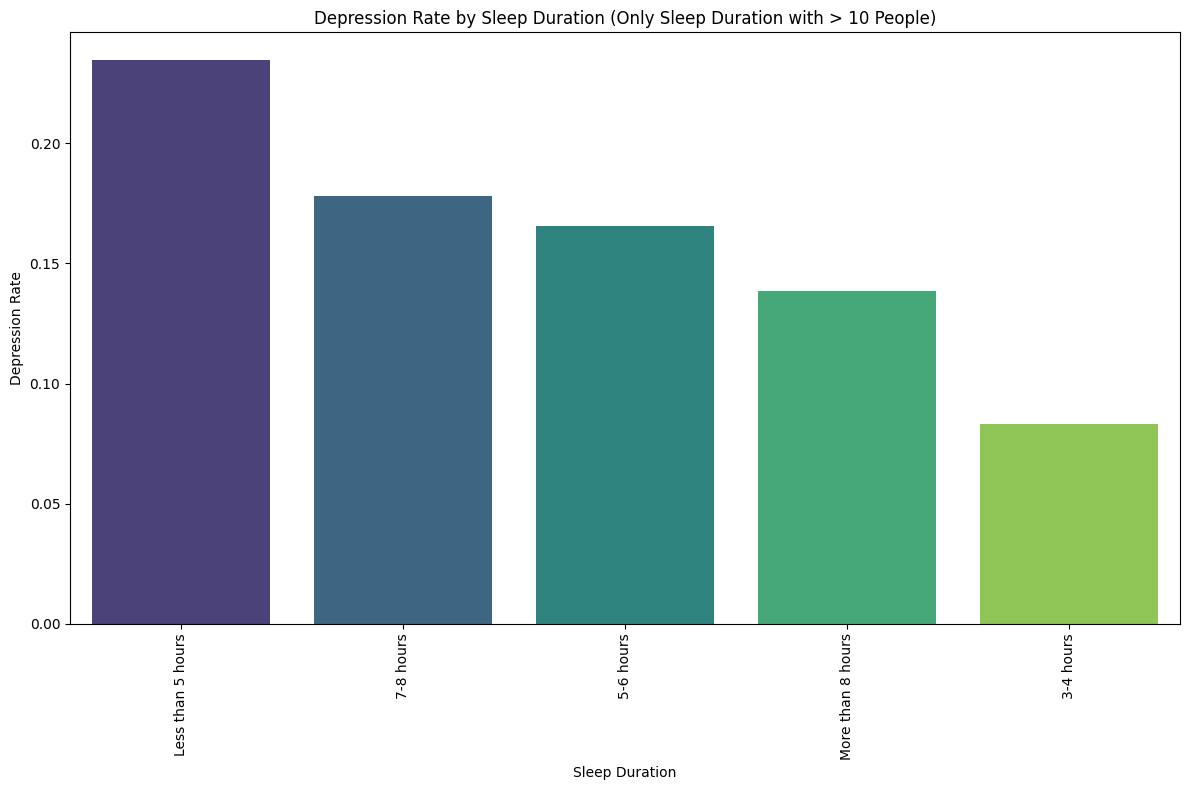

In [138]:
sleep_depression = train_df[train_df["Sleep Duration"].isin(sleep_counts.index)]
sleep_depression = sleep_depression.groupby("Sleep Duration")["Depression"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=sleep_depression.index, y=sleep_depression.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Depression Rate")
plt.title("Depression Rate by Sleep Duration (Only Sleep Duration with > 10 People)")
plt.tight_layout()
plt.show()

In [139]:
train_df["Sleep Duration"].unique()

array(['More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours',
       'Sleep_Duration', '1-2 hours', '6-8 hours', '4-6 hours',
       '6-7 hours', '10-11 hours', '8-9 hours', '40-45 hours',
       '9-11 hours', '2-3 hours', '3-4 hours', 'Moderate', '55-66 hours',
       '4-5 hours', '9-6 hours', '1-3 hours', 'Indore', '45', '1-6 hours',
       '35-36 hours', '8 hours', 'No', '10-6 hours', 'than 5 hours',
       '49 hours', 'Unhealthy', 'Work_Study_Hours', '3-6 hours',
       '45-48 hours', '9-5', 'Pune', '9-5 hours'], dtype=object)

In [140]:
test_df["Sleep Duration"].unique()

array(['Less than 5 hours', '7-8 hours', 'More than 8 hours', '5-6 hours',
       '0', 'Meerut', '9-5 hours', '6-7 hours', '60-65 hours', 'Vivan',
       '3-4 hours', '1-6 hours', '9-5', 'Unhealthy', '8-9 hours',
       '4-5 hours', 'than 5 hours', '9-6 hours', '1-2 hours',
       '8-89 hours', 'Have_you_ever_had_suicidal_thoughts', '20-21 hours',
       '10-6 hours', '1-3 hours', '6 hours', '50-75 hours', '4-6 hours',
       '2-3 hours', '9-11 hours', '9-10 hours', '3-6 hours'], dtype=object)

In [141]:
def CleanSleepDuration(duration):
    if duration in ["Less than 5 hours",'1-2 hours', '2-3 hours', '3-4 hours', '4-5 hours', '1-3 hours', '1-6 hours', '3-6 hours', '0']:
        return "Less than 5 Hours"
    elif duration in ["5-6 hours", "7-8 hours", "6-8 hours", "4-6 hours", "6-7 hours"]:
        return "Greater than 5 Hours Less than 8 Hours"
    elif duration in ["More than 8 hours", "10-11 hours", "8-9 hours", "9-11 hours", "8 hours", "8-89 hours", "9-10 hours"]:
        return "Greater than 8 Hours"
    else:
        return duration

train_df["Sleep Duration"] = train_df["Sleep Duration"].apply(CleanSleepDuration)
test_df["Sleep Duration"] = test_df["Sleep Duration"].apply(CleanSleepDuration)
allowed_durations = ['Less than 5 Hours', 'Greater than 5 Hours Less than 8 Hours', 'Greater than 8 Hours']
train_df['Sleep Duration'] = train_df['Sleep Duration'].where(train_df['Sleep Duration'].isin(allowed_durations), np.nan)
test_df['Sleep Duration'] = test_df['Sleep Duration'].where(test_df['Sleep Duration'].isin(allowed_durations), np.nan)

In [142]:
train_df["Sleep Duration"].unique()

array(['Greater than 8 Hours', 'Less than 5 Hours',
       'Greater than 5 Hours Less than 8 Hours', nan], dtype=object)

In [143]:
test_df["Sleep Duration"].unique()

array(['Less than 5 Hours', 'Greater than 5 Hours Less than 8 Hours',
       'Greater than 8 Hours', nan], dtype=object)

In [144]:
def GetMaleColumn(gender):
    if gender == "Male":
        return 1
    return 0
def GetFemaleColumn(gender):
    if gender == "Female":
        return 1
    return 0
train_df["Male"] = train_df["Gender"].apply(GetMaleColumn)
train_df["Female"] = train_df["Gender"].apply(GetFemaleColumn)
test_df["Male"] = test_df["Gender"].apply(GetMaleColumn)
test_df["Female"] = test_df["Gender"].apply(GetFemaleColumn)
train_df.drop(columns=["Gender"], inplace=True)
test_df.drop(columns=["Gender"], inplace=True)

In [145]:
train_df.columns

Index(['Age', 'Working Professional or Student', 'CGPA', 'Sleep Duration',
       'Dietary Habits', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression', 'Pressure',
       'Satisfaction', 'Currently in College or Studied till College Only',
       'Male', 'Female'],
      dtype='object')

In [146]:
def GetStudent(occ):
    if occ == "Student":
        return 1
    return 0
def GetProfessional(occ):
    if occ == "Working Professional":
        return 1
    return 0
train_df["Student"] = train_df['Working Professional or Student'].apply(GetStudent)
train_df["Professional"] = train_df["Working Professional or Student"].apply(GetProfessional)
test_df["Student"] = test_df["Working Professional or Student"].apply(GetStudent)
test_df["Professional"] = test_df["Working Professional or Student"].apply(GetProfessional)
train_df.drop(columns=["Working Professional or Student"], inplace=True)
test_df.drop(columns=["Working Professional or Student"], inplace=True)

In [147]:
train_df.columns

Index(['Age', 'CGPA', 'Sleep Duration', 'Dietary Habits',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression',
       'Pressure', 'Satisfaction',
       'Currently in College or Studied till College Only', 'Male', 'Female',
       'Student', 'Professional'],
      dtype='object')

In [148]:
train_df["Family History of Mental Illness"] = train_df["Family History of Mental Illness"].map({"Yes" : 1, "No" : 0})
test_df["Family History of Mental Illness"] = test_df["Family History of Mental Illness"].map({"Yes" : 1, "No" : 0})

In [149]:
train_df["Have you ever had suicidal thoughts ?"] = train_df["Have you ever had suicidal thoughts ?"].map({"Yes" : 1, "No" : 0})
test_df["Have you ever had suicidal thoughts ?"] = test_df["Have you ever had suicidal thoughts ?"].map({"Yes" : 1, "No" : 0})

In [150]:
categorical_cols = ['Sleep Duration', 'Dietary Habits']
encoders = {}

combined = pd.concat([train_df[categorical_cols], test_df[categorical_cols]], axis=0)

for col in categorical_cols:
    le = LabelEncoder()
    
    combined[col] = combined[col].astype(str)
    le.fit(combined[col].dropna())

    train_df[col] = train_df[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else np.nan)
    test_df[col] = test_df[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else np.nan)

    encoders[col] = le

In [151]:
imputer = KNNImputer(n_neighbors=9)

train_df[categorical_cols] = imputer.fit_transform(train_df[categorical_cols])
test_df[categorical_cols] = imputer.transform(test_df[categorical_cols])

In [152]:
for col in categorical_cols:
    le = encoders[col]
    
    train_df[col] = train_df[col].round().astype(int)
    test_df[col] = test_df[col].round().astype(int)

    train_df[col] = le.inverse_transform(train_df[col])
    test_df[col] = le.inverse_transform(test_df[col])

In [153]:
combined = pd.concat([train_df, test_df], axis=0)
combined_encoded = pd.get_dummies(combined, columns=categorical_cols, prefix=categorical_cols)

train_df = combined_encoded.iloc[:len(train_df)].copy()
test_df = combined_encoded.iloc[len(train_df):].copy()

In [154]:
train_df.shape

(140661, 20)

In [155]:
test_df.drop(columns=["Depression"], inplace=True)

In [156]:
train_df.head()

Age  CGPA  Have you ever had suicidal thoughts ?  Work/Study Hours  \
id                                                                        
0   49.0  0.00                                      0               1.0   
1   26.0  0.00                                      1               7.0   
2   33.0  8.97                                      1               3.0   
3   22.0  0.00                                      1              10.0   
4   30.0  0.00                                      1               9.0   

    Financial Stress  Family History of Mental Illness  Depression  Pressure  \
id                                                                             
0                2.0                                 0         0.0       5.0   
1                3.0                                 0         1.0       4.0   
2                1.0                                 0         1.0       5.0   
3                1.0                                 1         1.0       5.0   
4                4.0                                 1         0.0       1.0   

    Satisfaction  Currently in College or Studied till College Only  Male  \
id                                                                          
0            2.0                                                  0     0   
1            3.0                                                  0     1   
2            2.0                                                  0     1   
3            1.0                                                  0     1   
4            1.0                                                  0     0   

    Female  Student  Professional  \
id                                  
0        1        0             1   
1        0        0             1   
2        0        1             0   
3        0        0             1   
4        1        0             1   

    Sleep Duration_Greater than 5 Hours Less than 8 Hours  \
id                                                          
0                                               False       
1                                               False       
2                                                True       
3                                               False       
4                                                True       

    Sleep Duration_Greater than 8 Hours  Sleep Duration_Less than 5 Hours  \
id                                                                          
0                                  True                             False   
1                                 False                              True   
2                                 False                             False   
3                                 False                              True   
4                                 False                             False   

    Dietary Habits_Healthy  Dietary Habits_Moderate  Dietary Habits_Unhealthy  
id                                                                             
0                     True                    False                     False  
1                    False                    False                      True  
2                     True                    False                     False  
3                    False                     True                     False  
4                    False                    False                      True

In [157]:
bool_cols = train_df.select_dtypes(include='bool').columns
train_df[bool_cols] = train_df[bool_cols].astype(int)
test_df[bool_cols] = test_df[bool_cols].astype(int)

In [158]:
train_df.head()

Age  CGPA  Have you ever had suicidal thoughts ?  Work/Study Hours  \
id                                                                        
0   49.0  0.00                                      0               1.0   
1   26.0  0.00                                      1               7.0   
2   33.0  8.97                                      1               3.0   
3   22.0  0.00                                      1              10.0   
4   30.0  0.00                                      1               9.0   

    Financial Stress  Family History of Mental Illness  Depression  Pressure  \
id                                                                             
0                2.0                                 0         0.0       5.0   
1                3.0                                 0         1.0       4.0   
2                1.0                                 0         1.0       5.0   
3                1.0                                 1         1.0       5.0   
4                4.0                                 1         0.0       1.0   

    Satisfaction  Currently in College or Studied till College Only  Male  \
id                                                                          
0            2.0                                                  0     0   
1            3.0                                                  0     1   
2            2.0                                                  0     1   
3            1.0                                                  0     1   
4            1.0                                                  0     0   

    Female  Student  Professional  \
id                                  
0        1        0             1   
1        0        0             1   
2        0        1             0   
3        0        0             1   
4        1        0             1   

    Sleep Duration_Greater than 5 Hours Less than 8 Hours  \
id                                                          
0                                                   0       
1                                                   0       
2                                                   1       
3                                                   0       
4                                                   1       

    Sleep Duration_Greater than 8 Hours  Sleep Duration_Less than 5 Hours  \
id                                                                          
0                                     1                                 0   
1                                     0                                 1   
2                                     0                                 0   
3                                     0                                 1   
4                                     0                                 0   

    Dietary Habits_Healthy  Dietary Habits_Moderate  Dietary Habits_Unhealthy  
id                                                                             
0                        1                        0                         0  
1                        0                        0                         1  
2                        1                        0                         0  
3                        0                        1                         0  
4                        0                        0                         1

In [159]:
bins = [0, 20, 29, 39, float('inf')]
labels = ['Teenagers', 'Young Adults', 'Adults', 'Middle-aged and Older']

def GetTeenagers(age):
    if age <= 20:
        return 1
    return 0
def GetYoungAdults(age):
    if age > 20 and age <= 29:
        return 1
    return 0
def GetAdults(age):
    if age >= 30 and age <= 39:
        return 1
    return 0
def GetOld(age):
    if age >= 40:
        return 1
    return 0

train_df.Age = train_df.Age.astype(int)
test_df.Age = test_df.Age.astype(int)

train_df["Teenager"] = train_df["Age"].apply(GetTeenagers)
train_df["Young Adults"] = train_df["Age"].apply(GetYoungAdults)
train_df["Adults"] = train_df["Age"].apply(GetAdults)
train_df["Middle-aged and Older"] = train_df["Age"].apply(GetTeenagers)

test_df["Teenager"] = test_df["Age"].apply(GetTeenagers)
test_df["Young Adults"] = test_df["Age"].apply(GetYoungAdults)
test_df["Adults"] = test_df["Age"].apply(GetAdults)
test_df["Middle-aged and Older"] = test_df["Age"].apply(GetOld)


In [160]:
train_df.columns

Index(['Age', 'CGPA', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression', 'Pressure',
       'Satisfaction', 'Currently in College or Studied till College Only',
       'Male', 'Female', 'Student', 'Professional',
       'Sleep Duration_Greater than 5 Hours Less than 8 Hours',
       'Sleep Duration_Greater than 8 Hours',
       'Sleep Duration_Less than 5 Hours', 'Dietary Habits_Healthy',
       'Dietary Habits_Moderate', 'Dietary Habits_Unhealthy', 'Teenager',
       'Young Adults', 'Adults', 'Middle-aged and Older'],
      dtype='object')

In [161]:
train_df.shape

(140661, 24)

In [162]:
test_df.shape

(93800, 23)

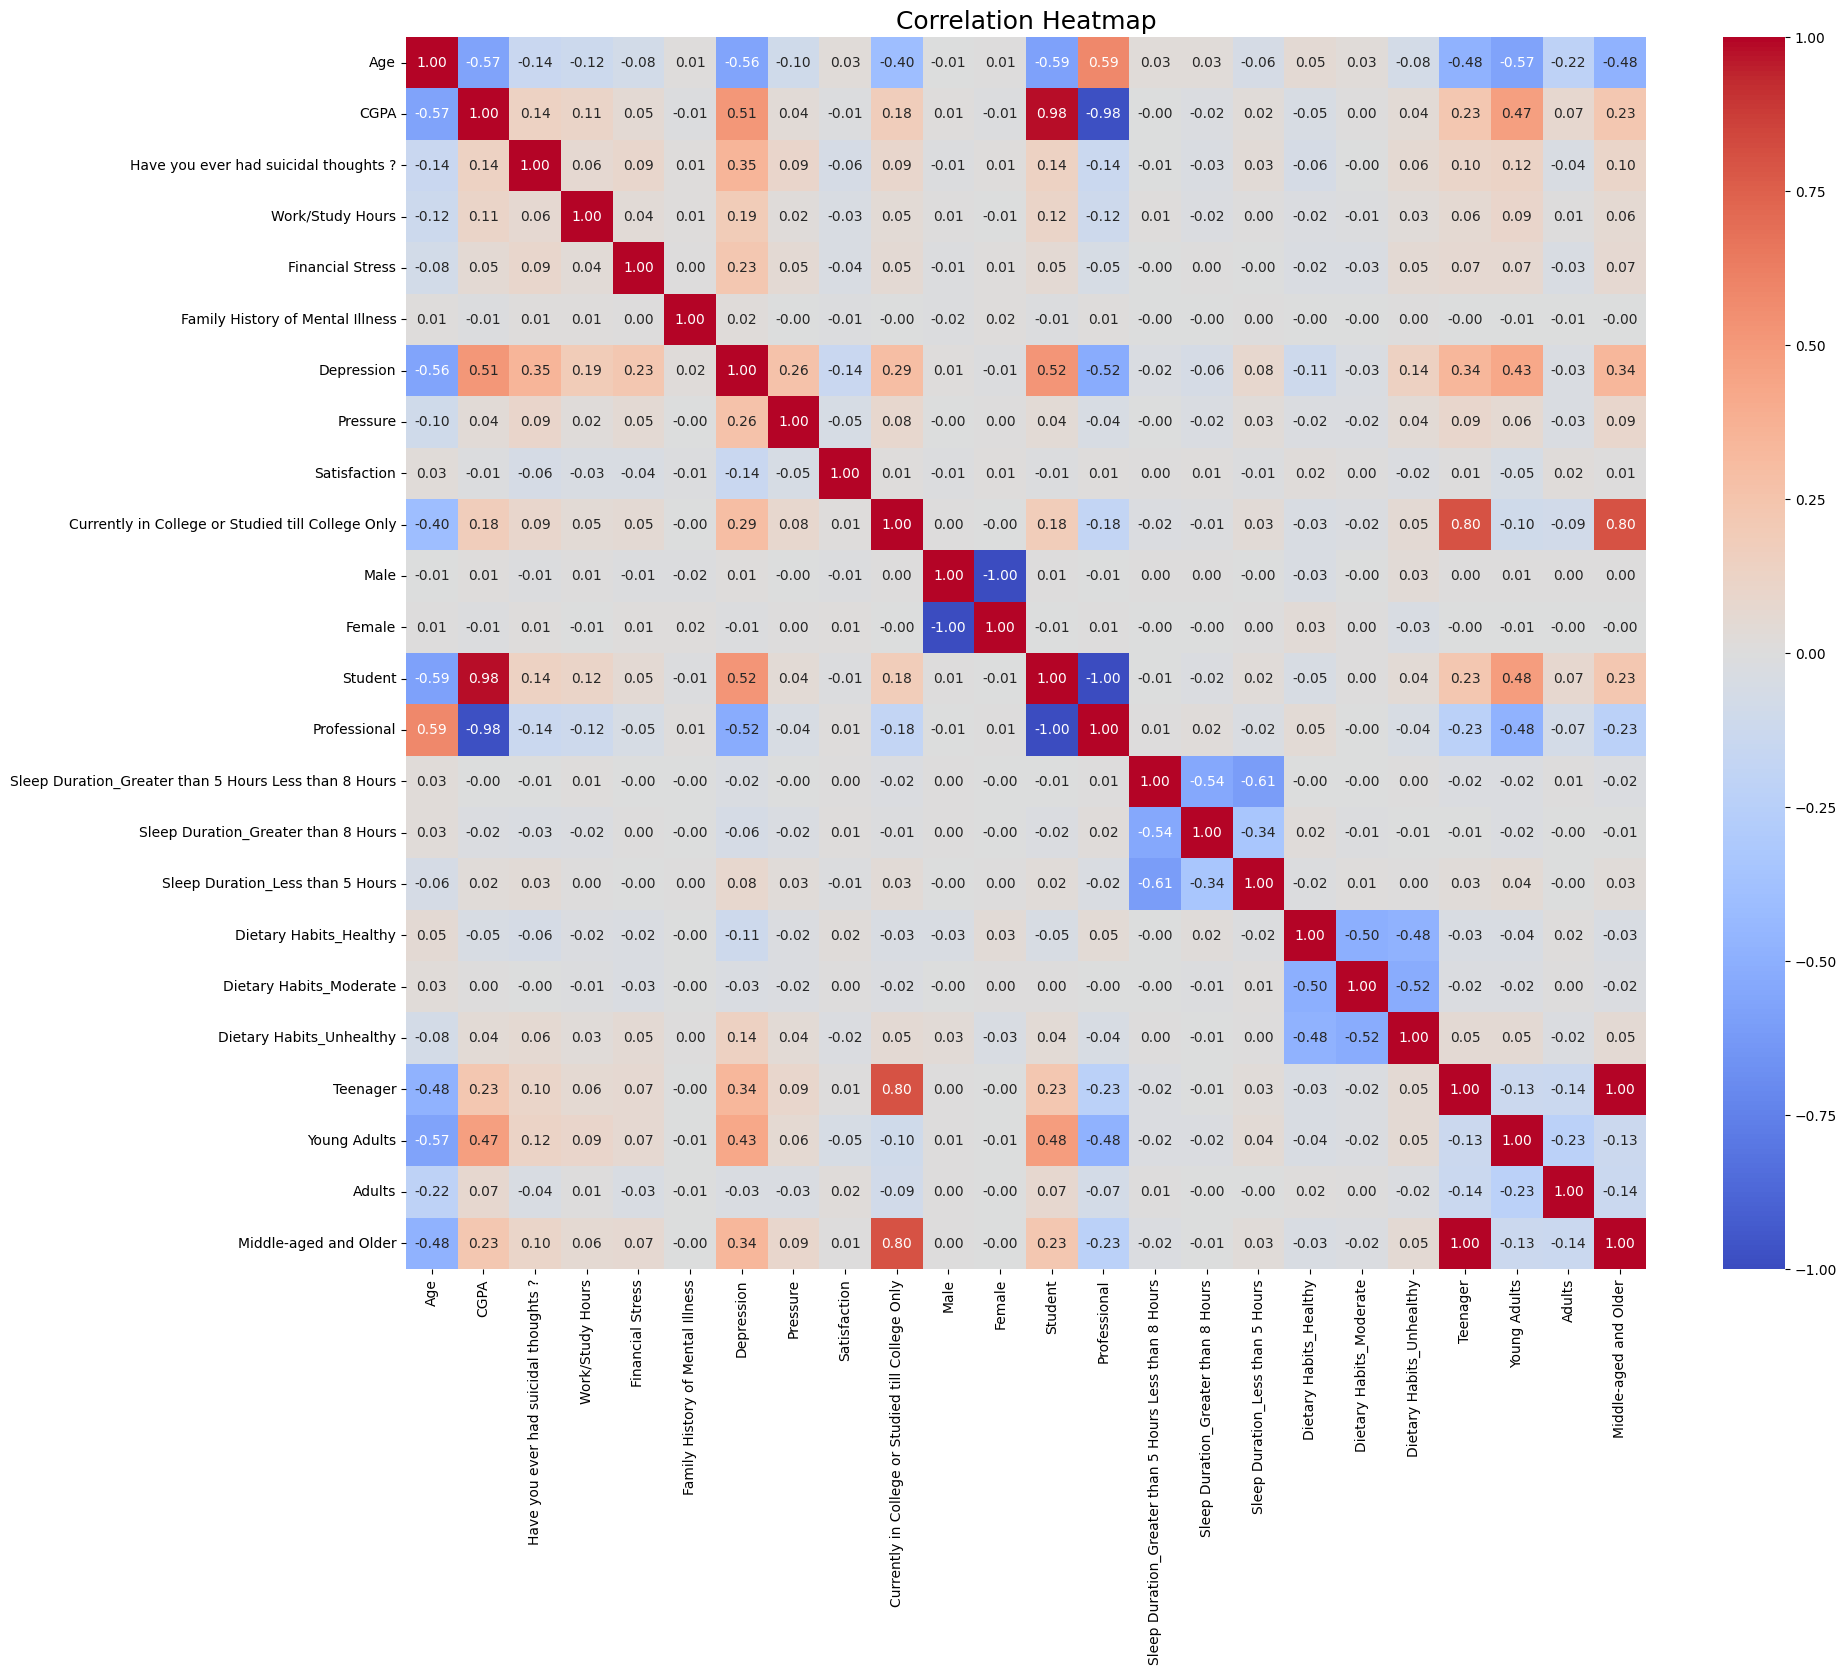

In [163]:
corr = train_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr, fmt='.2f', annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap', fontsize=18)
plt.show()

# Model Training

In [164]:
X = train_df.drop(columns=["Depression"])
Y = train_df.Depression.astype(int)

In [165]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logisitc Regression

In [597]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9372978352824085
Recall: 0.8034088708115437
Precision: 0.84704921380437
F1: 0.824652087475149


## Decision Tree Classifier

In [598]:
dt_clr = DecisionTreeClassifier(random_state=42)
dt_clr.fit(X_train, Y_train)
Y_pred = dt_clr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9034585717840259
Recall: 0.7381367422041448
Precision: 0.7364251207729469
F1: 0.7372799380924744


## Random Forest Classifier

In [599]:
rf_clr = RandomForestClassifier(random_state=42)
rf_clr.fit(X_train, Y_train)
Y_pred = rf_clr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9354850175949952
Recall: 0.7937245787332946
Precision: 0.8452970297029703
F1: 0.818699430626311


## Gradient Boosting Classfier

In [603]:
gb_clr = GradientBoostingClassifier(random_state=42)
gb_clr.fit(X_train, Y_train)
Y_pred = gb_clr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9383641986279458
Recall: 0.8014720123958938
Precision: 0.8537239529605942
F1: 0.8267732267732268


## Extra Trees Classifier

In [604]:
et_clr = ExtraTreesClassifier(random_state=42)
et_clr.fit(X_train, Y_train)
Y_pred = et_clr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9315394732165073
Recall: 0.7840402866550455
Precision: 0.8330932290594772
F1: 0.8078227898623029


## Ada Boost Classifier

In [606]:
ada_clr = AdaBoostClassifier(random_state=42)
ada_clr.fit(X_train, Y_train)
Y_pred = ada_clr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9375821988412185
Recall: 0.8072825876428433
Precision: 0.8456076283221748
F1: 0.8260007927070948


## Bagging Classifier

In [607]:
bg_clr = BaggingClassifier(random_state=42)
bg_clr.fit(X_train, Y_train)
Y_pred = bg_clr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9281982014004905
Recall: 0.757892698043773
Precision: 0.8355754857997011
F1: 0.794840544383506


## SVC

In [608]:
svc = SVC(random_state=42)
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9362314719368713
Recall: 0.7943056362579896
Precision: 0.8485412787088765
F1: 0.8205282112845138


## Gaussian Naive Bayes

In [610]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_pred = gnb.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.8697259446201969
Recall: 0.8016656982374588
Precision: 0.6104719764011799
F1: 0.6931256803148287


## XGB Classifier

In [611]:
xgb_clr = xgb.XGBClassifier(random_state=42)
xgb_clr.fit(X_train, Y_train)
Y_pred = xgb_clr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9377599260654748
Recall: 0.8068952159597134
Precision: 0.8467479674796748
F1: 0.826341366656749


## LinearSVC

In [614]:
l_svc = LinearSVC(random_state=42)
l_svc.fit(X_train, Y_train)
Y_pred = l_svc.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

Accuracy: 0.9375466533963672
Recall: 0.8065078442765834
Precision: 0.8459975619666802
F1: 0.8257808626673276


## LGBM Classifier

In [616]:
lgbm_clr = LGBMClassifier(random_state=42, metric="f1")
lgbm_clr.fit(X_train, Y_train)
Y_pred = lgbm_clr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

[LightGBM] [Info] Number of positive: 20384, number of negative: 92144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181146 -> initscore=-1.508602
[LightGBM] [Info] Start training from score -1.508602
Accuracy: 0.9387907439661607
Recall: 0.8103815611078831
Precision: 0.8491982951085854
F1: 0.8293359762140734


## CatBoost Classifer

In [180]:
cb_clr = CatBoostClassifier(random_state=42, iterations= 1500, depth= 5, learning_rate=0.08603261391075692, l2_leaf_reg=6.720099274789348)
cb_clr.fit(X_train, Y_train)
Y_pred = cb_clr.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

0:	learn: 0.5580847	total: 10.9ms	remaining: 16.4s
1:	learn: 0.4579311	total: 22.7ms	remaining: 17s
2:	learn: 0.3879601	total: 34ms	remaining: 16.9s
3:	learn: 0.3393137	total: 44.9ms	remaining: 16.8s
4:	learn: 0.3020616	total: 56ms	remaining: 16.7s
5:	learn: 0.2761071	total: 68.6ms	remaining: 17.1s
6:	learn: 0.2574860	total: 81.3ms	remaining: 17.3s
7:	learn: 0.2438890	total: 92.1ms	remaining: 17.2s
8:	learn: 0.2309465	total: 103ms	remaining: 17.1s
9:	learn: 0.2208270	total: 118ms	remaining: 17.6s
10:	learn: 0.2128982	total: 129ms	remaining: 17.4s
11:	learn: 0.2064551	total: 139ms	remaining: 17.3s
12:	learn: 0.2004467	total: 150ms	remaining: 17.2s
13:	learn: 0.1960422	total: 161ms	remaining: 17.1s
14:	learn: 0.1925566	total: 174ms	remaining: 17.2s
15:	learn: 0.1887715	total: 185ms	remaining: 17.2s
16:	learn: 0.1861425	total: 195ms	remaining: 17s
17:	learn: 0.1837850	total: 206ms	remaining: 17s
18:	learn: 0.1816914	total: 217ms	remaining: 17s
19:	learn: 0.1796323	total: 229ms	remaining: 

In [622]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
log_model = LogisticRegression(random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('xgboost', xgb_model),
        ('lightgbm', lgbm_model),
        ('logreg', log_model)
    ],
    voting='hard' 
)

voting_clf.fit(X_train, Y_train)

Y_pred = voting_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")
print(f"Recall: {recall_score(Y_test, Y_pred)}")
print(f"Precision: {precision_score(Y_test, Y_pred)}")
print(f"F1: {f1_score(Y_test, Y_pred)}")

[LightGBM] [Info] Number of positive: 20384, number of negative: 92144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181146 -> initscore=-1.508602
[LightGBM] [Info] Start training from score -1.508602
Accuracy: 0.9390395620801194
Recall: 0.799535153980244
Precision: 0.8585690515806988
F1: 0.8280012034901214


In [623]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
log_model = LogisticRegression(random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('xgboost', xgb_model),
        ('lightgbm', lgbm_model),
        ('logreg', log_model)
    ],
    voting='hard' 
)

voting_clf.fit(X, Y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 25547, number of negative: 115114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 140661, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181621 -> initscore=-1.505403
[LightGBM] [Info] Start training from score -1.505403


VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7d7d180e5290>),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lightgbm', LGBMClassifier(random_state=42)),
                             ('logreg', LogisticRegression(random_state=42))])

In [625]:
Y_pred = voting_clf.predict(test_df)

In [181]:
df = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv", index_col="id")
ids = df.index
ids

Index([140700, 140701, 140702, 140703, 140704, 140705, 140706, 140707, 140708,
       140709,
       ...
       234490, 234491, 234492, 234493, 234494, 234495, 234496, 234497, 234498,
       234499],
      dtype='int64', name='id', length=93800)

In [627]:
submission_df = pd.DataFrame({"id": ids, "Depression": Y_pred})

In [628]:
submission_df.head()

id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0

In [629]:
submission_df.to_csv('submission-1.0.csv', index=False)

# Hyperparameter Tuning

In [633]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [634]:
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    return cross_val_score(model, X, Y, cv=cv, scoring='accuracy').mean()

study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=30)
cat_best_params = study_cat.best_params

[I 2025-07-24 00:39:18,805] A new study created in memory with name: no-name-e6934cdf-96a8-4294-9ddf-1ea891fc6937
[I 2025-07-24 00:39:58,132] Trial 0 finished with value: 0.93687661847576 and parameters: {'iterations': 425, 'depth': 7, 'learning_rate': 0.18067462321636224, 'l2_leaf_reg': 2.202732325999971}. Best is trial 0 with value: 0.93687661847576.
[I 2025-07-24 00:40:40,960] Trial 1 finished with value: 0.9379856661742749 and parameters: {'iterations': 250, 'depth': 9, 'learning_rate': 0.0902515846922038, 'l2_leaf_reg': 3.3202701821788128}. Best is trial 1 with value: 0.9379856661742749.
[I 2025-07-24 00:41:01,101] Trial 2 finished with value: 0.9391373742188197 and parameters: {'iterations': 320, 'depth': 4, 'learning_rate': 0.17816917052494677, 'l2_leaf_reg': 2.1660781159214335}. Best is trial 2 with value: 0.9391373742188197.
[I 2025-07-24 00:42:11,305] Trial 3 finished with value: 0.9359168593712781 and parameters: {'iterations': 287, 'depth': 10, 'learning_rate': 0.1095529092

In [635]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = xgb.XGBClassifier(**params)
    return cross_val_score(model, X, Y, cv=cv, scoring='accuracy').mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)
xgb_best_params = study_xgb.best_params

[I 2025-07-24 00:55:39,950] A new study created in memory with name: no-name-7c85432b-1b54-4ddb-92b2-f53a56679fec
[I 2025-07-24 00:55:53,067] Trial 0 finished with value: 0.9389809689546752 and parameters: {'n_estimators': 472, 'max_depth': 3, 'learning_rate': 0.054843983244212434, 'subsample': 0.7447048517303162, 'colsample_bytree': 0.984125239680513}. Best is trial 0 with value: 0.9389809689546752.
[I 2025-07-24 00:56:06,239] Trial 1 finished with value: 0.9378790285761976 and parameters: {'n_estimators': 484, 'max_depth': 4, 'learning_rate': 0.23698788000253168, 'subsample': 0.891076644261553, 'colsample_bytree': 0.6653591036549574}. Best is trial 0 with value: 0.9389809689546752.
[I 2025-07-24 00:56:13,109] Trial 2 finished with value: 0.9387321475555552 and parameters: {'n_estimators': 222, 'max_depth': 4, 'learning_rate': 0.14219852310968592, 'subsample': 0.7429550153496535, 'colsample_bytree': 0.9676181542036608}. Best is trial 0 with value: 0.9389809689546752.
[I 2025-07-24 00:

In [636]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = LGBMClassifier(**params)
    return cross_val_score(model, X, Y, cv=cv, scoring='accuracy').mean()

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30)
lgbm_best_params = study_lgbm.best_params


[I 2025-07-24 01:01:30,123] A new study created in memory with name: no-name-bb5c9142-d0af-431f-a4ef-06dd5e5c738b


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:01:40,986] Trial 0 finished with value: 0.9388601103989055 and parameters: {'n_estimators': 316, 'max_depth': 3, 'learning_rate': 0.23941290920846786, 'num_leaves': 117, 'subsample': 0.8075019971871402, 'colsample_bytree': 0.6060960257143986}. Best is trial 0 with value: 0.9388601103989055.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20438, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

[I 2025-07-24 01:01:59,512] Trial 1 finished with value: 0.9342177459165205 and parameters: {'n_estimators': 310, 'max_depth': 9, 'learning_rate': 0.17994283022750035, 'num_leaves': 99, 'subsample': 0.5120711109622507, 'colsample_bytree': 0.8296578792791129}. Best is trial 0 with value: 0.9388601103989055.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20438, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

[I 2025-07-24 01:02:06,745] Trial 2 finished with value: 0.9369334952307975 and parameters: {'n_estimators': 138, 'max_depth': 9, 'learning_rate': 0.20422600336107583, 'num_leaves': 57, 'subsample': 0.8065302605481337, 'colsample_bytree': 0.9113096519773176}. Best is trial 0 with value: 0.9388601103989055.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:02:13,862] Trial 3 finished with value: 0.9377368349196711 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.044553814930478865, 'num_leaves': 81, 'subsample': 0.9339519197944498, 'colsample_bytree': 0.777290242546081}. Best is trial 0 with value: 0.9388601103989055.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20438, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

[I 2025-07-24 01:02:21,962] Trial 4 finished with value: 0.9385259756361624 and parameters: {'n_estimators': 176, 'max_depth': 10, 'learning_rate': 0.14826572464187854, 'num_leaves': 20, 'subsample': 0.8032662904984179, 'colsample_bytree': 0.6946990519176628}. Best is trial 0 with value: 0.9388601103989055.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20438, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

[I 2025-07-24 01:02:43,278] Trial 5 finished with value: 0.9312673971716349 and parameters: {'n_estimators': 331, 'max_depth': 10, 'learning_rate': 0.2605734850708994, 'num_leaves': 145, 'subsample': 0.9006642642633266, 'colsample_bytree': 0.935238687283237}. Best is trial 0 with value: 0.9388601103989055.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:03:12,190] Trial 6 finished with value: 0.9332011133421624 and parameters: {'n_estimators': 445, 'max_depth': 8, 'learning_rate': 0.20746449004729864, 'num_leaves': 94, 'subsample': 0.5700793918324683, 'colsample_bytree': 0.7224440656013249}. Best is trial 0 with value: 0.9388601103989055.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:03:24,865] Trial 7 finished with value: 0.9392866671088325 and parameters: {'n_estimators': 347, 'max_depth': 3, 'learning_rate': 0.12272532999787401, 'num_leaves': 27, 'subsample': 0.9829698863935705, 'colsample_bytree': 0.6786820290535776}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20438, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

[I 2025-07-24 01:03:42,440] Trial 8 finished with value: 0.9352841385758046 and parameters: {'n_estimators': 469, 'max_depth': 9, 'learning_rate': 0.21905342669624084, 'num_leaves': 36, 'subsample': 0.5503965944397575, 'colsample_bytree': 0.8112764746775378}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:03:58,169] Trial 9 finished with value: 0.9379572247642998 and parameters: {'n_estimators': 417, 'max_depth': 3, 'learning_rate': 0.02414801385734159, 'num_leaves': 137, 'subsample': 0.7478674738201374, 'colsample_bytree': 0.7177811031493466}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-07-24 01:04:20,235] Trial 10 finished with value: 0.9371965375876098 and parameters: {'n_estimators': 388, 'max_depth': 6, 'learning_rate': 0.12130496691167612, 'num_leaves': 65, 'subsample': 0.9950125396684459, 'colsample_bytree': 0.519901067162007}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:04:32,049] Trial 11 finished with value: 0.9366206915255357 and parameters: {'n_estimators': 235, 'max_depth': 5, 'learning_rate': 0.29587451601556236, 'num_leaves': 117, 'subsample': 0.6739167785361172, 'colsample_bytree': 0.590093711419195}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:04:41,146] Trial 12 finished with value: 0.9389525315879753 and parameters: {'n_estimators': 245, 'max_depth': 3, 'learning_rate': 0.09229082024649982, 'num_leaves': 119, 'subsample': 0.8741177502704118, 'colsample_bytree': 0.6099400481728381}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:04:53,423] Trial 13 finished with value: 0.9389738568332484 and parameters: {'n_estimators': 240, 'max_depth': 5, 'learning_rate': 0.0882160659244312, 'num_leaves': 45, 'subsample': 0.9072916422304631, 'colsample_bytree': 0.6307916067015502}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-07-24 01:05:06,746] Trial 14 finished with value: 0.9390165118724794 and parameters: {'n_estimators': 246, 'max_depth': 5, 'learning_rate': 0.08152420702983604, 'num_leaves': 39, 'subsample': 0.9969551258911524, 'colsample_bytree': 0.6576032528530471}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20438, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 350
[LightGBM] [Info] Number of data points in the train set: 112529, number of used

[I 2025-07-24 01:05:22,903] Trial 15 finished with value: 0.9389667500186206 and parameters: {'n_estimators': 375, 'max_depth': 6, 'learning_rate': 0.05999892361729317, 'num_leaves': 20, 'subsample': 0.994471943053175, 'colsample_bytree': 0.6800158074115951}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-07-24 01:05:35,168] Trial 16 finished with value: 0.9388814356441786 and parameters: {'n_estimators': 276, 'max_depth': 4, 'learning_rate': 0.1334219279016519, 'num_leaves': 40, 'subsample': 0.9498441246828303, 'colsample_bytree': 0.5033692487146564}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-07-24 01:05:48,131] Trial 17 finished with value: 0.937907465437488 and parameters: {'n_estimators': 208, 'max_depth': 7, 'learning_rate': 0.09228618547030504, 'num_leaves': 68, 'subsample': 0.686520713463134, 'colsample_bytree': 0.6581851184190425}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-07-24 01:06:01,695] Trial 18 finished with value: 0.9383980064751943 and parameters: {'n_estimators': 355, 'max_depth': 4, 'learning_rate': 0.170707567046844, 'num_leaves': 33, 'subsample': 0.8557841887736672, 'colsample_bytree': 0.866119302967959}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-07-24 01:06:08,032] Trial 19 finished with value: 0.9384548799450705 and parameters: {'n_estimators': 105, 'max_depth': 5, 'learning_rate': 0.1111925365856416, 'num_leaves': 54, 'subsample': 0.9560474630442505, 'colsample_bytree': 0.5536931975101425}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-07-24 01:06:24,704] Trial 20 finished with value: 0.9378008263231825 and parameters: {'n_estimators': 276, 'max_depth': 7, 'learning_rate': 0.059291893982979, 'num_leaves': 75, 'subsample': 0.848679261883457, 'colsample_bytree': 0.9887735351810171}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:06:35,982] Trial 21 finished with value: 0.9387250316435578 and parameters: {'n_estimators': 206, 'max_depth': 5, 'learning_rate': 0.09488531675519983, 'num_leaves': 48, 'subsample': 0.9134208426796568, 'colsample_bytree': 0.6405377301733747}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:06:50,325] Trial 22 finished with value: 0.9390307333355811 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.07034779999486898, 'num_leaves': 31, 'subsample': 0.9988762904234723, 'colsample_bytree': 0.7661617017967312}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:07:02,532] Trial 23 finished with value: 0.9342177358083321 and parameters: {'n_estimators': 277, 'max_depth': 4, 'learning_rate': 0.0108460329412947, 'num_leaves': 33, 'subsample': 0.9728690112167082, 'colsample_bytree': 0.7538382064165117}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20438, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_c

[I 2025-07-24 01:07:18,199] Trial 24 finished with value: 0.9390094037943278 and parameters: {'n_estimators': 343, 'max_depth': 6, 'learning_rate': 0.06692458994175264, 'num_leaves': 24, 'subsample': 0.9945297906605038, 'colsample_bytree': 0.7879649422838689}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-07-24 01:07:37,375] Trial 25 finished with value: 0.9383055898348094 and parameters: {'n_estimators': 499, 'max_depth': 4, 'learning_rate': 0.14124810113854686, 'num_leaves': 30, 'subsample': 0.9455693567168145, 'colsample_bytree': 0.7358743107307103}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:07:48,367] Trial 26 finished with value: 0.9381207408863472 and parameters: {'n_estimators': 282, 'max_depth': 3, 'learning_rate': 0.04058886061794434, 'num_leaves': 54, 'subsample': 0.8823551192106468, 'colsample_bytree': 0.6871383220818237}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-07-24 01:08:04,525] Trial 27 finished with value: 0.9385117551838796 and parameters: {'n_estimators': 362, 'max_depth': 5, 'learning_rate': 0.1097880018144615, 'num_leaves': 45, 'subsample': 0.7272196216301613, 'colsample_bytree': 0.8566094086261727}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:08:27,835] Trial 28 finished with value: 0.9376444258604277 and parameters: {'n_estimators': 406, 'max_depth': 7, 'learning_rate': 0.07528241067721529, 'num_leaves': 62, 'subsample': 0.9287406112382396, 'colsample_bytree': 0.5703938711932347}. Best is trial 7 with value: 0.9392866671088325.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20437, number of negative: 92091
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 112528, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181617 -> initscore=-1.505430
[LightGBM] [Info] Start training from score -1.505430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-07-24 01:08:38,348] Trial 29 finished with value: 0.9389738593602954 and parameters: {'n_estimators': 302, 'max_depth': 3, 'learning_rate': 0.17323174173116168, 'num_leaves': 30, 'subsample': 0.8332016489844232, 'colsample_bytree': 0.7633188933880352}. Best is trial 7 with value: 0.9392866671088325.


In [637]:
def objective_logreg(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 10.0),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
        'max_iter': 1000,
        'random_state': 42
    }
    model = LogisticRegression(**params)
    return cross_val_score(model, X, Y, cv=cv, scoring='accuracy').mean()

study_log = optuna.create_study(direction='maximize')
study_log.optimize(objective_logreg, n_trials=30)
log_best_params = study_log.best_params


[I 2025-07-24 01:08:38,357] A new study created in memory with name: no-name-602e7571-2be8-495e-86dd-b82f0ae290a9
[I 2025-07-24 01:09:02,831] Trial 0 finished with value: 0.9372320729242725 and parameters: {'C': 0.34020318065811256, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9372320729242725.
[I 2025-07-24 01:09:26,259] Trial 1 finished with value: 0.937189416621518 and parameters: {'C': 4.934851955321979, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9372320729242725.
[I 2025-07-24 01:09:49,588] Trial 2 finished with value: 0.9372178537355131 and parameters: {'C': 0.4728909774499145, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9372320729242725.
[I 2025-07-24 01:09:54,676] Trial 3 finished with value: 0.9371680888491978 and parameters: {'C': 0.5983817167776276, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.9372320729242725.
[I 2025-07-24 01:09:59,808] Trial 4 finished with value: 0.937175198190

In [638]:
cat_model = CatBoostClassifier(**cat_best_params)
xgb_model = xgb.XGBClassifier(**xgb_best_params)
lgbm_model = LGBMClassifier(**lgbm_best_params)
log_model = LogisticRegression(**log_best_params)

voting_clf = VotingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('xgboost', xgb_model),
        ('lightgbm', lgbm_model),
        ('logreg', log_model)
    ],
    voting='hard'
)

voting_clf.fit(X, Y)

0:	learn: 0.5638765	total: 15.4ms	remaining: 5.22s
1:	learn: 0.4674817	total: 30.4ms	remaining: 5.15s
2:	learn: 0.4006416	total: 45.5ms	remaining: 5.12s
3:	learn: 0.3495952	total: 59.7ms	remaining: 5.03s
4:	learn: 0.3141155	total: 74.3ms	remaining: 5s
5:	learn: 0.2878513	total: 88.2ms	remaining: 4.92s
6:	learn: 0.2691161	total: 103ms	remaining: 4.89s
7:	learn: 0.2528473	total: 117ms	remaining: 4.88s
8:	learn: 0.2423549	total: 131ms	remaining: 4.84s
9:	learn: 0.2322522	total: 145ms	remaining: 4.81s
10:	learn: 0.2248908	total: 160ms	remaining: 4.8s
11:	learn: 0.2187769	total: 174ms	remaining: 4.76s
12:	learn: 0.2138280	total: 187ms	remaining: 4.72s
13:	learn: 0.2081257	total: 201ms	remaining: 4.69s
14:	learn: 0.2029081	total: 215ms	remaining: 4.67s
15:	learn: 0.1985428	total: 230ms	remaining: 4.66s
16:	learn: 0.1949508	total: 244ms	remaining: 4.66s
17:	learn: 0.1916659	total: 259ms	remaining: 4.64s
18:	learn: 0.1886741	total: 273ms	remaining: 4.62s
19:	learn: 0.1862951	total: 287ms	remai

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7d7d180eaad0>),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7842730383082062,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, g...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=356, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lightgbm',
                              LGBMClassifier(colsample_bytree=0.6786820290535776,
                                             learning_rate=0.12272532999787401,
                                             max_depth=3, n_estimators=347,
                                             num_leaves=27,
                                             subsample=0.9829698863935705)),
                             ('logreg',
                              LogisticRegression(C=8.864746919752573))])

In [639]:
Y_pred = voting_clf.predict(test_df)

In [643]:
submission_df = pd.DataFrame({"id": ids, "Depression": Y_pred})

In [645]:
submission_df.to_csv('submission-2.csv', index=False)

In [182]:
cb_clr.fit(X, Y)
Y_pred = cb_clr.predict(test_df)

0:	learn: 0.5567605	total: 15.7ms	remaining: 23.6s
1:	learn: 0.4590379	total: 27.9ms	remaining: 20.9s
2:	learn: 0.3877787	total: 40.5ms	remaining: 20.2s
3:	learn: 0.3387182	total: 52.4ms	remaining: 19.6s
4:	learn: 0.3034174	total: 64.8ms	remaining: 19.4s
5:	learn: 0.2764671	total: 77.4ms	remaining: 19.3s
6:	learn: 0.2566866	total: 90.1ms	remaining: 19.2s
7:	learn: 0.2405189	total: 102ms	remaining: 19.1s
8:	learn: 0.2298974	total: 115ms	remaining: 19s
9:	learn: 0.2201093	total: 128ms	remaining: 19s
10:	learn: 0.2125116	total: 140ms	remaining: 18.9s
11:	learn: 0.2068157	total: 153ms	remaining: 18.9s
12:	learn: 0.2016751	total: 165ms	remaining: 18.8s
13:	learn: 0.1974082	total: 178ms	remaining: 18.9s
14:	learn: 0.1922554	total: 191ms	remaining: 18.9s
15:	learn: 0.1892557	total: 201ms	remaining: 18.7s
16:	learn: 0.1855033	total: 215ms	remaining: 18.7s
17:	learn: 0.1829240	total: 228ms	remaining: 18.8s
18:	learn: 0.1797425	total: 242ms	remaining: 18.9s
19:	learn: 0.1776993	total: 255ms	rema

In [183]:
submission_df = pd.DataFrame({"id": ids, "Depression": Y_pred})

In [184]:
submission_df.to_csv('submission-3.csv', index=False)

In [185]:
joblib.dump(cb_clr, "depression_prediction_model.pkl")

['depression_prediction_model.pkl']

In [166]:
joblib.dump(scaler, "depression_prediction_scaler.pkl")

['depression_prediction_scaler.pkl']